## Weights from GM model

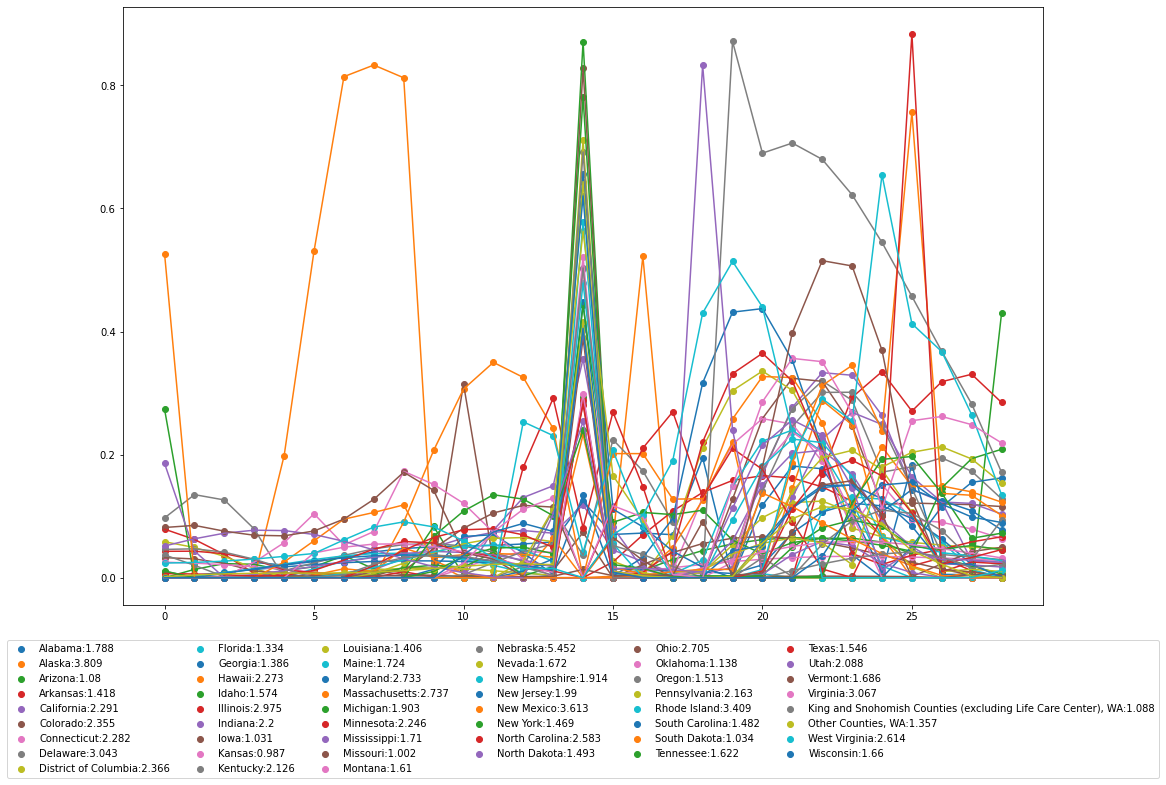

In [11]:
import dill as pickle
import matplotlib.pyplot as plt

from db_queries import get_location_metadata

loc_df = get_location_metadata(location_set_version_id=630, location_set_id=111)
loc_df = loc_df.loc[loc_df['path_to_top_parent'].str.startswith('102,')]
loc_df = loc_df.loc[loc_df['most_detailed'] == 1]
loc_df = loc_df.loc[~loc_df['location_id'].isin([573, 60406])]
loc_id = 555

plt.figure(figsize=(16.5, 11))
for loc_id in loc_df.location_id:
    with open(f'/ihme/covid-19/deaths/dev/2020_04_25_US_point/model_data_google_21/{loc_id}/gaussian_mixtures.pkl', 'rb') as fopen:
        gm = pickle.load(fopen)

    plt.scatter(np.arange(gm[f'_{loc_id}'].weights.size),
                gm[f'_{loc_id}'].weights, 
                label = f"{loc_df.loc[loc_df['location_id'] == loc_id, 'location_name'].item()}:{np.round(gm[f'_{loc_id}'].weights.sum(), 3)}")
    plt.plot(np.arange(gm[f'_{loc_id}'].weights.size),
                gm[f'_{loc_id}'].weights)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)
plt.show()


## Play around with down-sampling

In [ ]:
import os

import dill as pickle

import numpy as np
import pandas as pd

from scipy.signal import resample

import matplotlib.pyplot as plt


location_name = 'California'
location_id = '_527'
pop = 36.9e6
n_draws = 111

with open(f'/ihme/covid-19/deaths/prod/2020_04_13_US/model_data_equal_21/{location_name}/draws.pkl', 'rb') as fopen:
    draws = pickle.load(fopen)

orig_draws = np.exp(draws[location_id][1]) * pop
# ds_draws = np.arange(orig_draws.shape[0], step=orig_draws.shape[0]/n_draws)
# ds_draws = [int(i) for i in ds_draws]
# assert len(ds_draws) == n_draws, 'Draw length not correct.'
# downsample_draws = orig_draws[ds_draws]
downsample_draws = resample(orig_draws, n_draws, axis=0)
downsample_draws = downsample_draws[np.argsort(downsample_draws[:,-1]),:]

orig_draws = orig_draws[:,1:] - orig_draws[:,:-1]
downsample_draws = downsample_draws[:,1:] - downsample_draws[:,:-1]

plt.figure(figsize=(11, 8.5))
plt.fill_between(draws[location_id][0][1:],
                np.percentile(orig_draws, 2.5, axis=0),
                np.percentile(orig_draws, 97.5, axis=0),
                color='dodgerblue', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         orig_draws.mean(axis=0), color='dodgerblue', label='Full draws')
plt.fill_between(draws[location_id][0][1:],
                np.percentile(downsample_draws, 2.5, axis=0),
                np.percentile(downsample_draws, 97.5, axis=0),
                color='firebrick', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         downsample_draws.mean(axis=0), color='firebrick', label='Downsampled draws', linestyle='--')
plt.legend(loc=2)
plt.show()


In [ ]:
?resample

## plot peaks (should add data to this)

In [ ]:
import matplotlib.pyplot as plt

pred_df = pd.read_csv(f'{OUTPUT_DIR}/point_estimates.csv', index=False)
pred_df['Date']
peak_dates_df = pd.read_csv(f'{OUTPUT_DIR}/peak_dates.csv', index=False)

for location_id in pred_df.location_id.unique():
    plt.plot(pred_df.loc[pred_df['location_id'] == location_id, 'Date'],
             pred_df.loc[pred_df['location_id'] == location_id, 'Daily death rate'],
             color='dodgerblue')
    plt.axvline(peak_dates_df.loc[peak_dates_df['location_id'] == location_id, 'Date'].item(),
                color='red', linestyle='--')
    plt.title(location_id)
    plt.show()


## plot raw + smoothed data, then predicted

/ihme/code/covid-19/deaths/conda/miniconda3/envs/covid_dev_2020_04_27/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/ihme/code/covid-19/deaths/conda/miniconda3/envs/covid_dev_2020_04_27/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


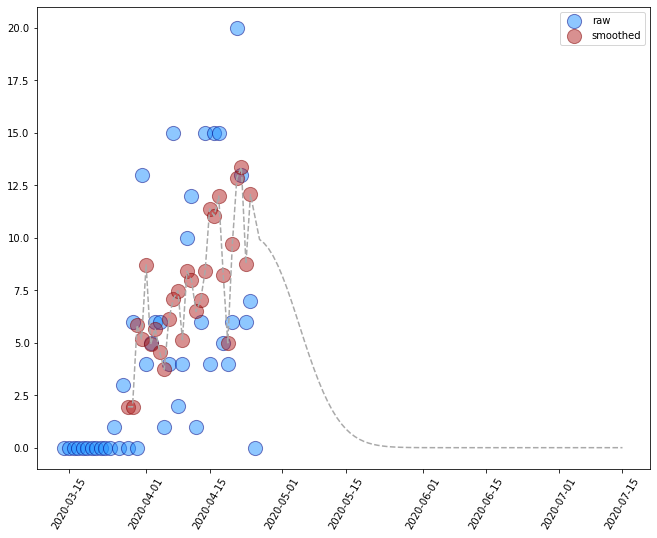

In [24]:
draw_cols = [f'draw_{d}' for d in range(1000)]

smooth_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_25_US_point/smoothed_state_data.csv')
smooth_df = smooth_df.loc[smooth_df['location_id'] == 523]
smooth_df['date'] = pd.to_datetime(smooth_df['date'])
smooth_df = smooth_df.sort_values('date').reset_index(drop=True)

raw_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_25_US_point/state_data.csv')
raw_df = raw_df.loc[raw_df['location_id'] == 523]
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.sort_values('date').reset_index(drop=True)

smooth_delta = (smooth_df[draw_cols].values[1:] - smooth_df[draw_cols].values[:-1]).mean(axis=1)
raw_delta = (raw_df[draw_cols].values[1:] - raw_df[draw_cols].values[:-1]).mean(axis=1)

smooth_df['daily'] = np.nan
smooth_df['daily'][1:] = smooth_delta
raw_df['daily'] = np.nan
raw_df['daily'][1:] = raw_delta

smooth_df = smooth_df[['date', 'observed', 'daily']][1:].reset_index(drop=True)
raw_df = raw_df[['date', 'observed', 'daily']][1:].reset_index(drop=True)

pred_date = raw_df.loc[~raw_df['observed'], 'date'].min()

import matplotlib.pyplot as plt

plt.figure(figsize=(11, 8.5))
plt.scatter(raw_df.loc[raw_df['date'] < pred_date, 'date'], 
            raw_df.loc[raw_df['date'] < pred_date, 'daily'], 
            c='dodgerblue', edgecolors='navy', alpha=0.5, s=200, label='raw')
plt.scatter(smooth_df.loc[smooth_df['date'] < pred_date, 'date'], 
            smooth_df.loc[smooth_df['date'] < pred_date, 'daily'], 
            c='firebrick', edgecolors='maroon', alpha=0.5, s=200, label='smoothed')
plt.plot(smooth_df['date'], 
         smooth_df['daily'], 
         color='darkgrey', linestyle='--')
plt.xticks(rotation=60)
plt.legend()
plt.show()


## look at testing effect

523


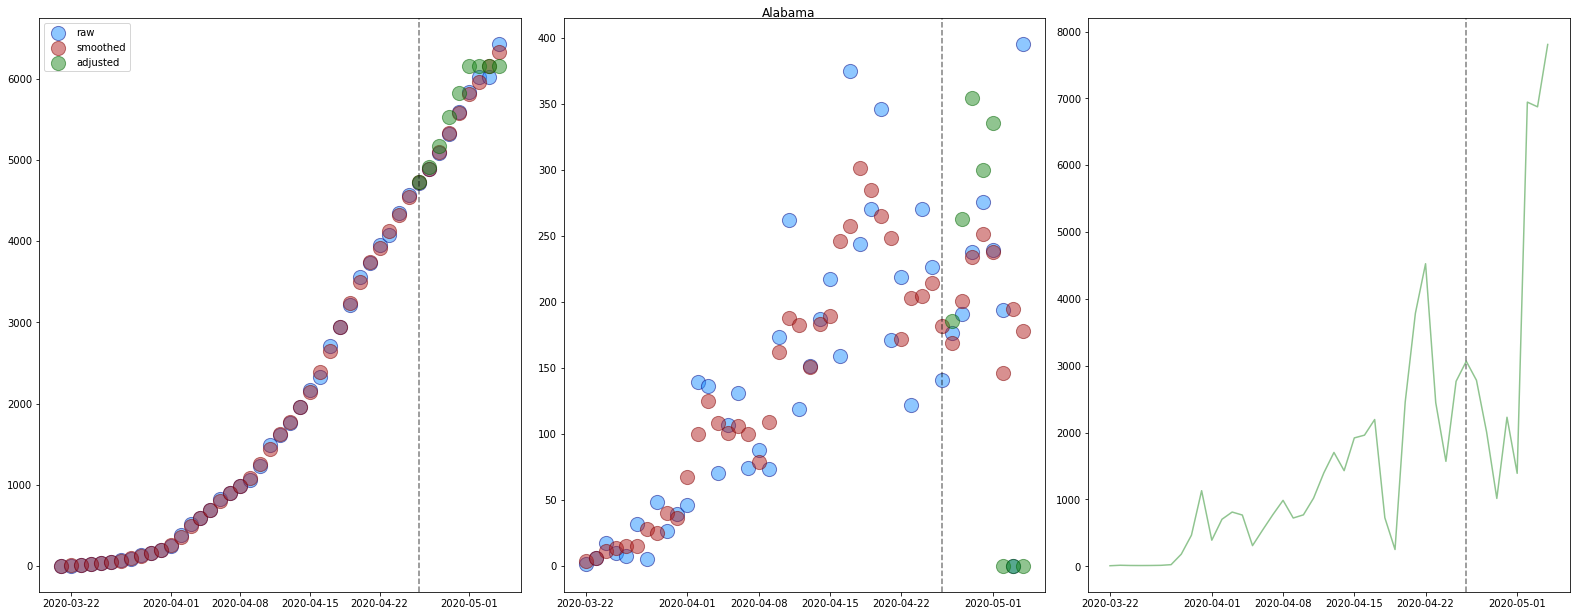

524


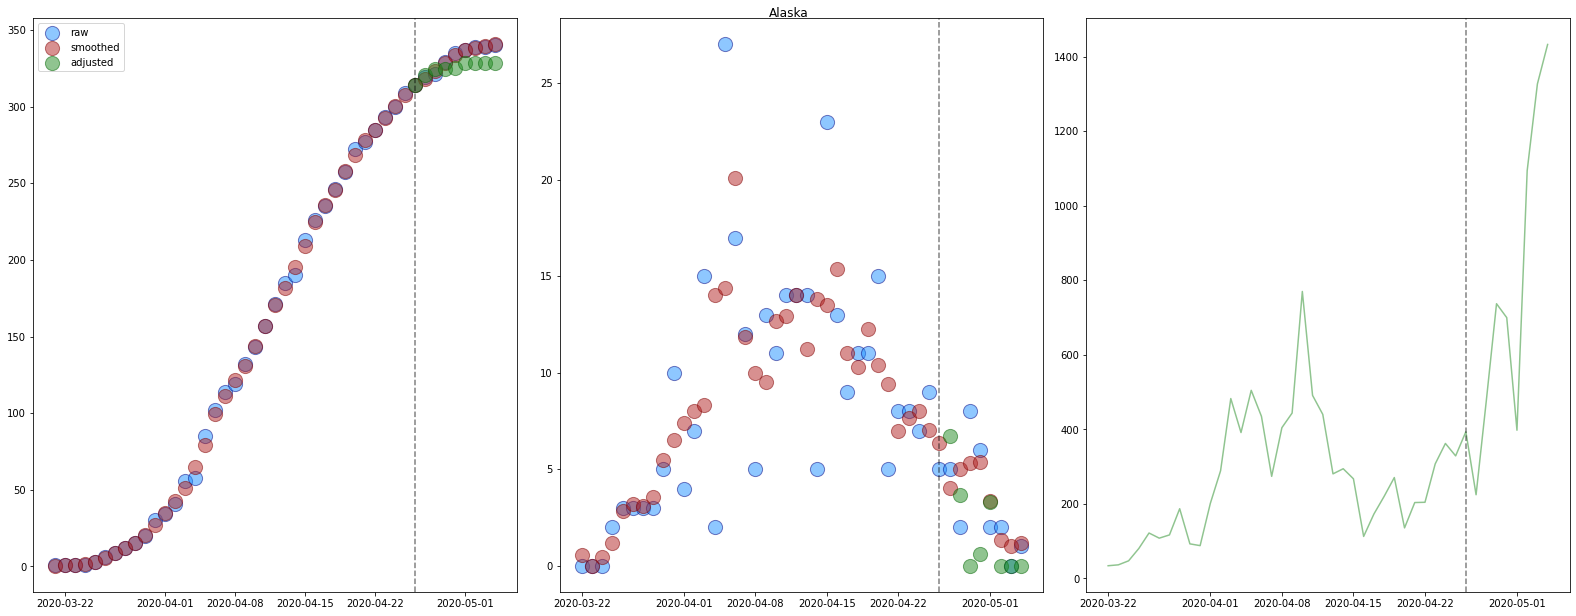

525


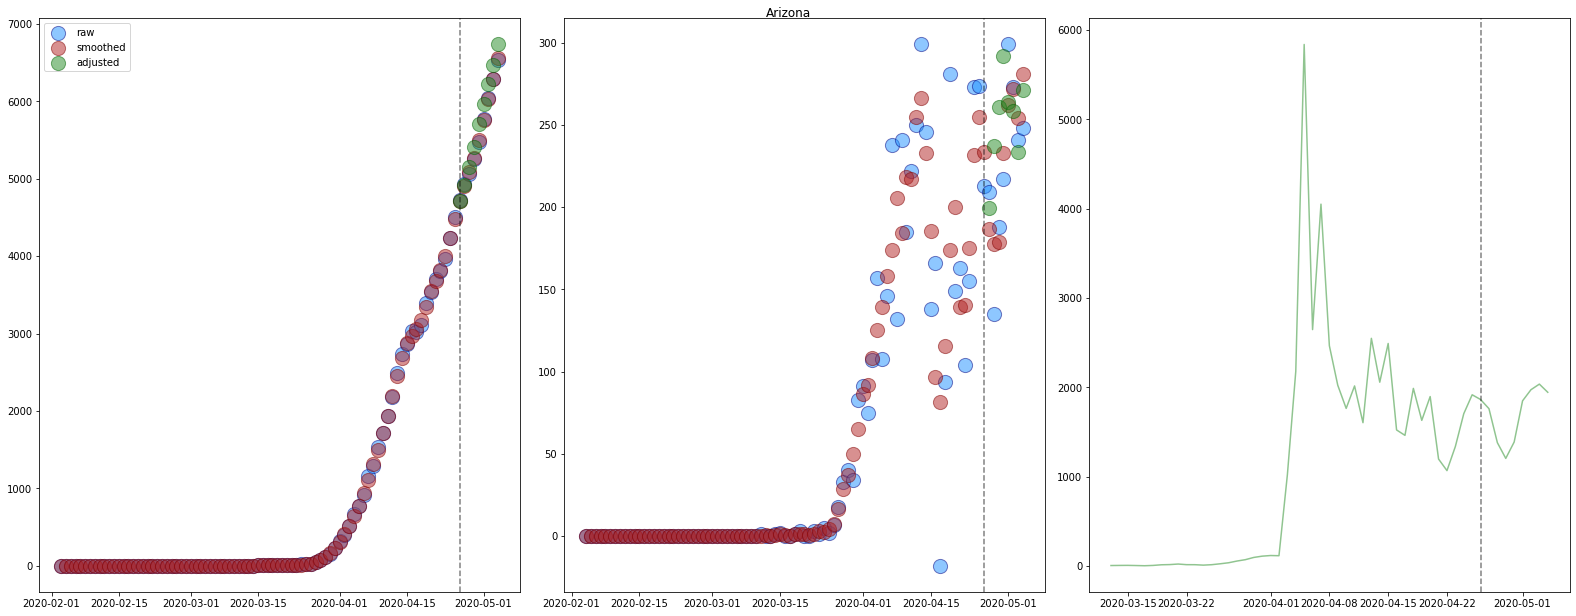

526


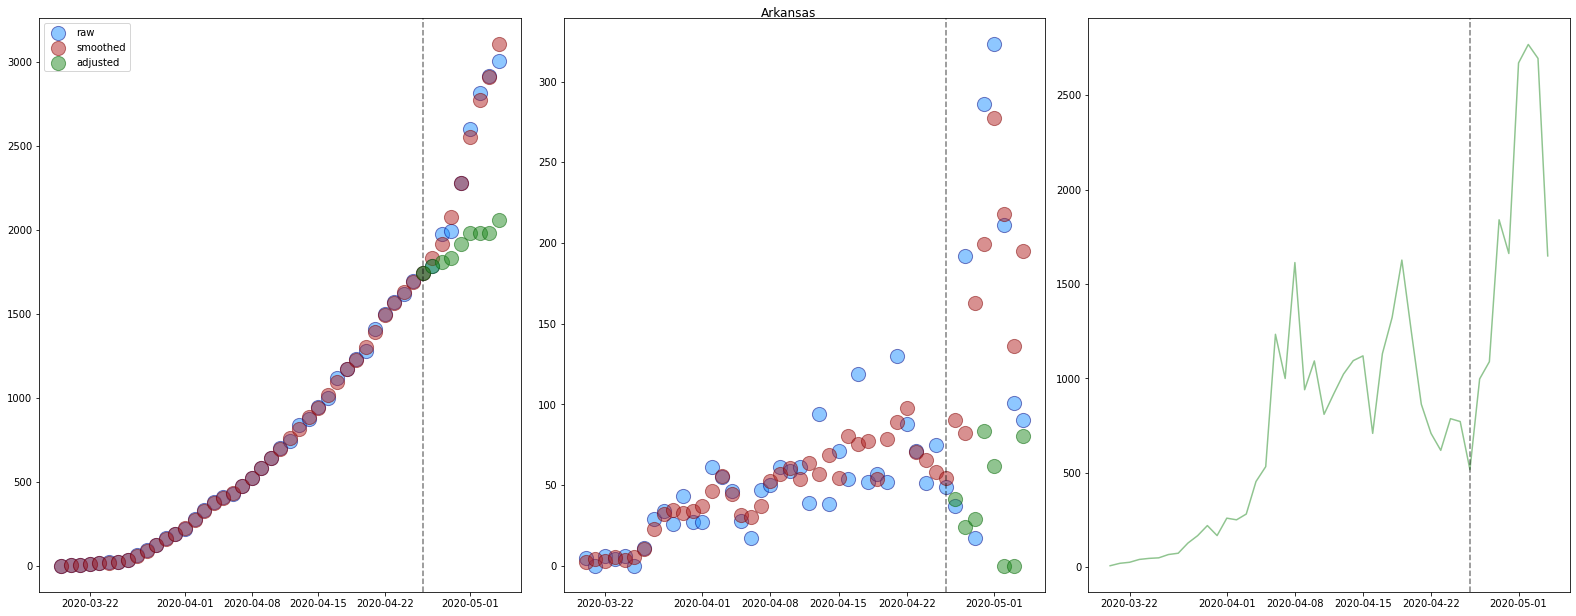

527


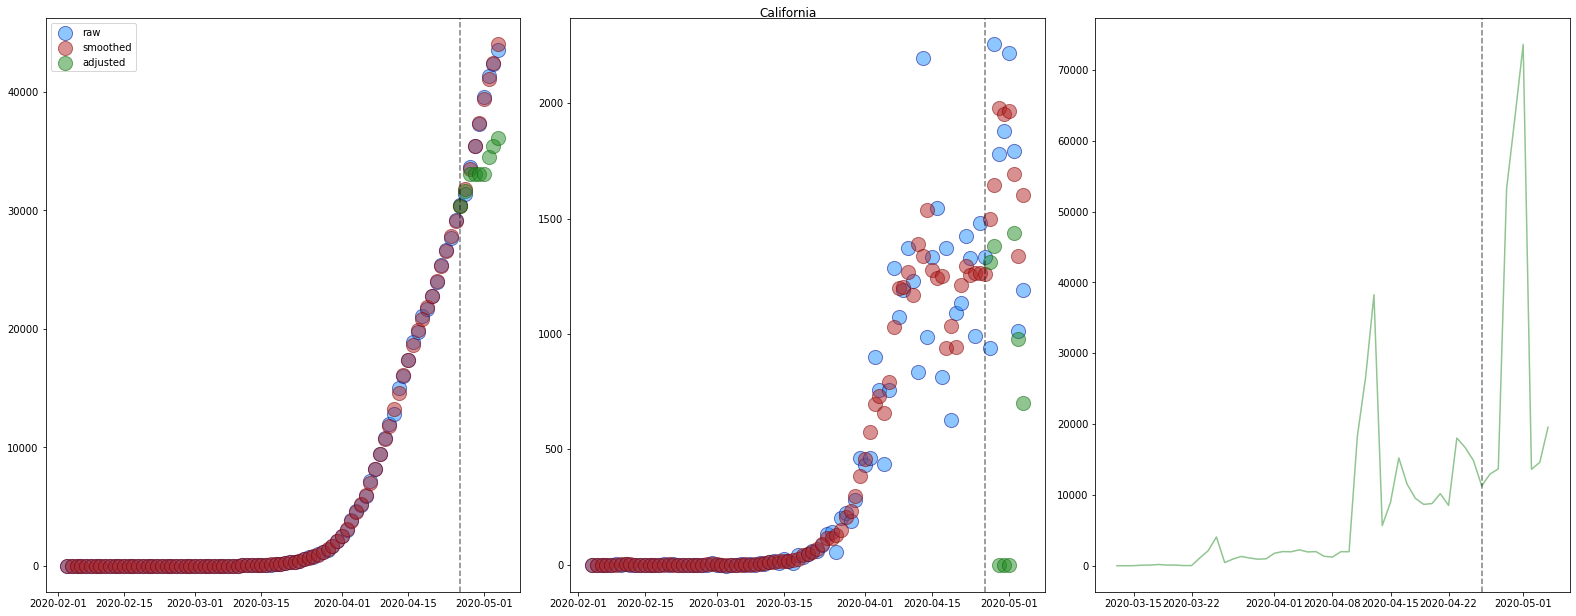

528


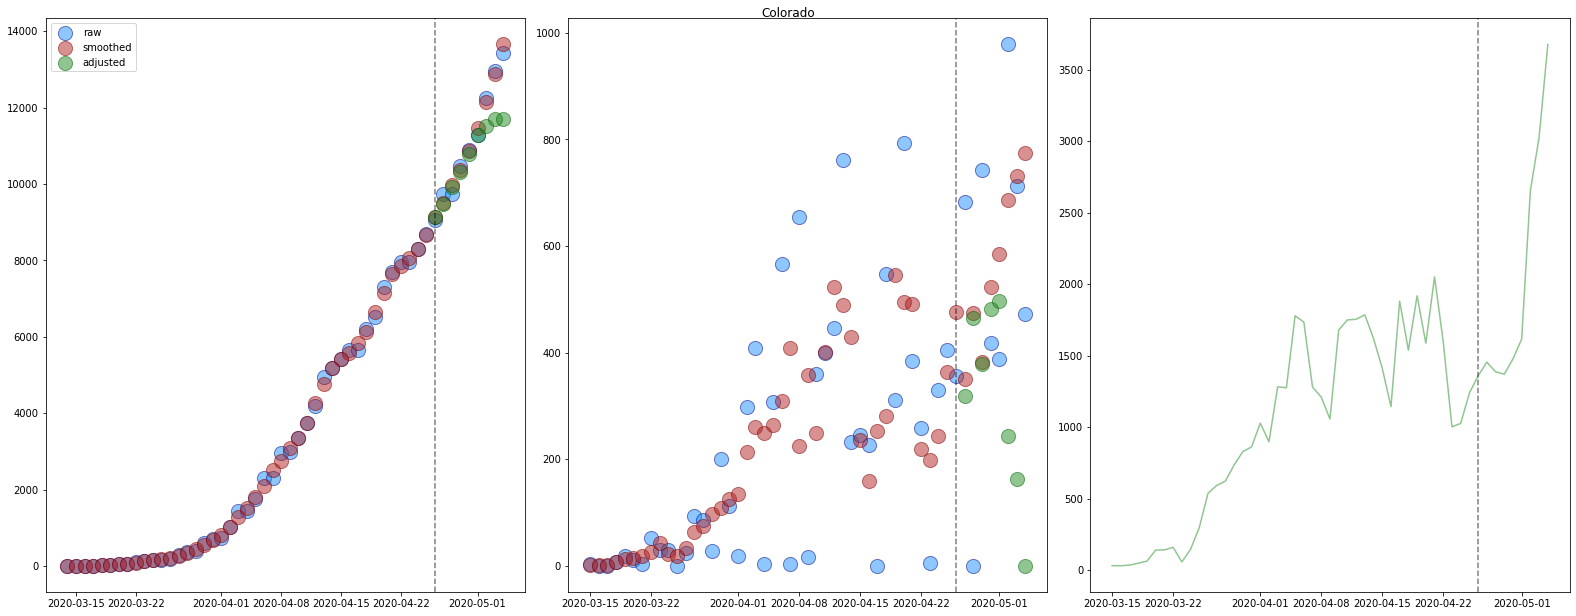

529


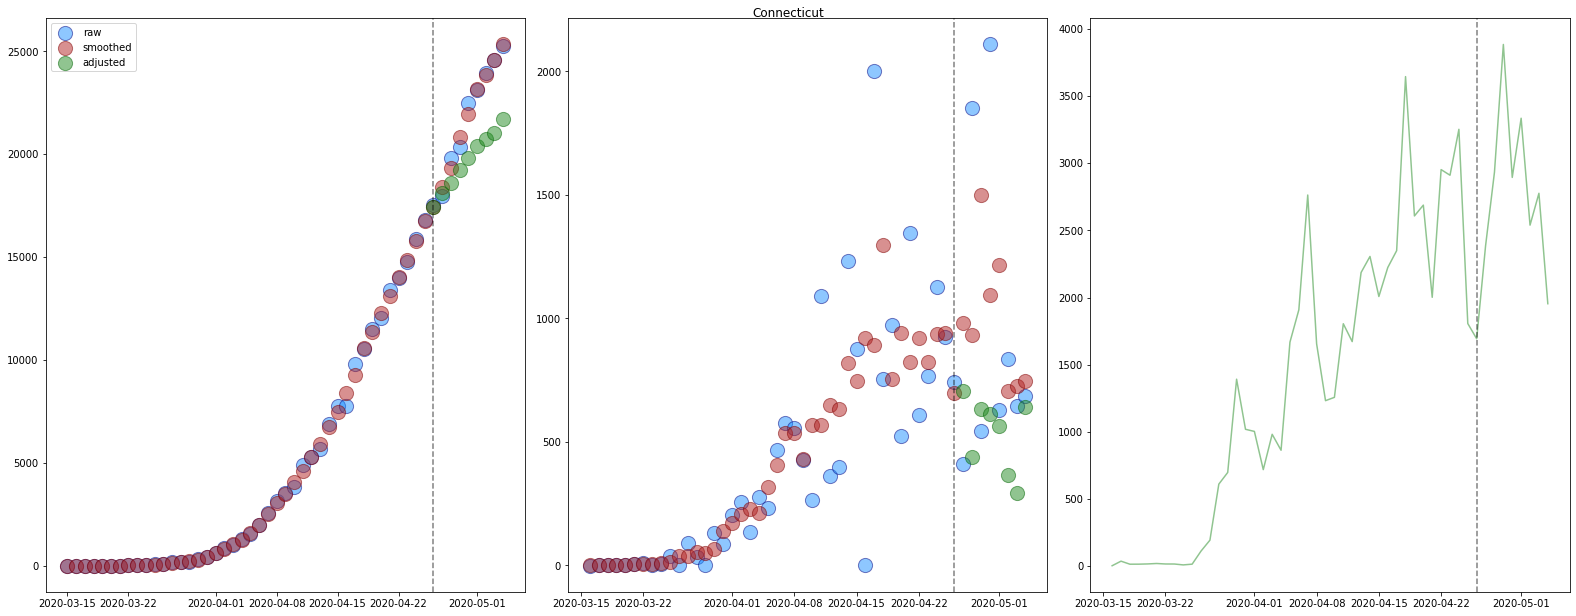

530


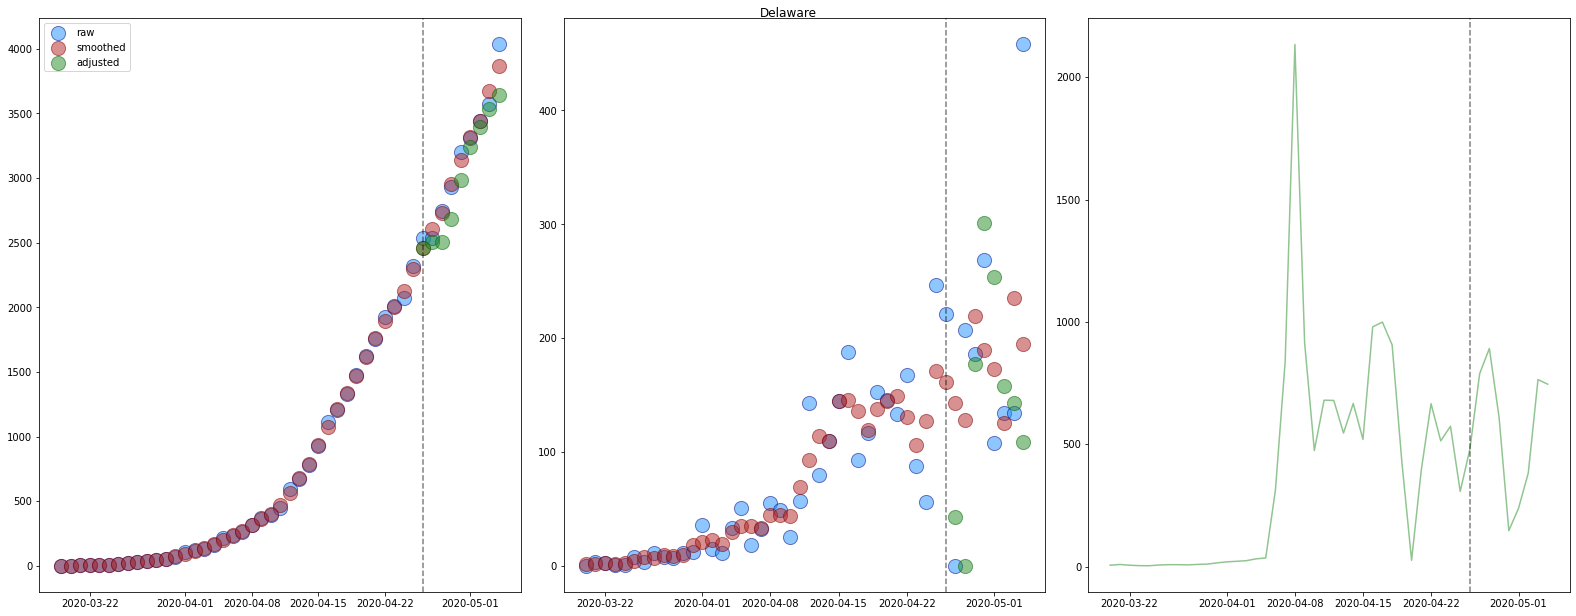

531


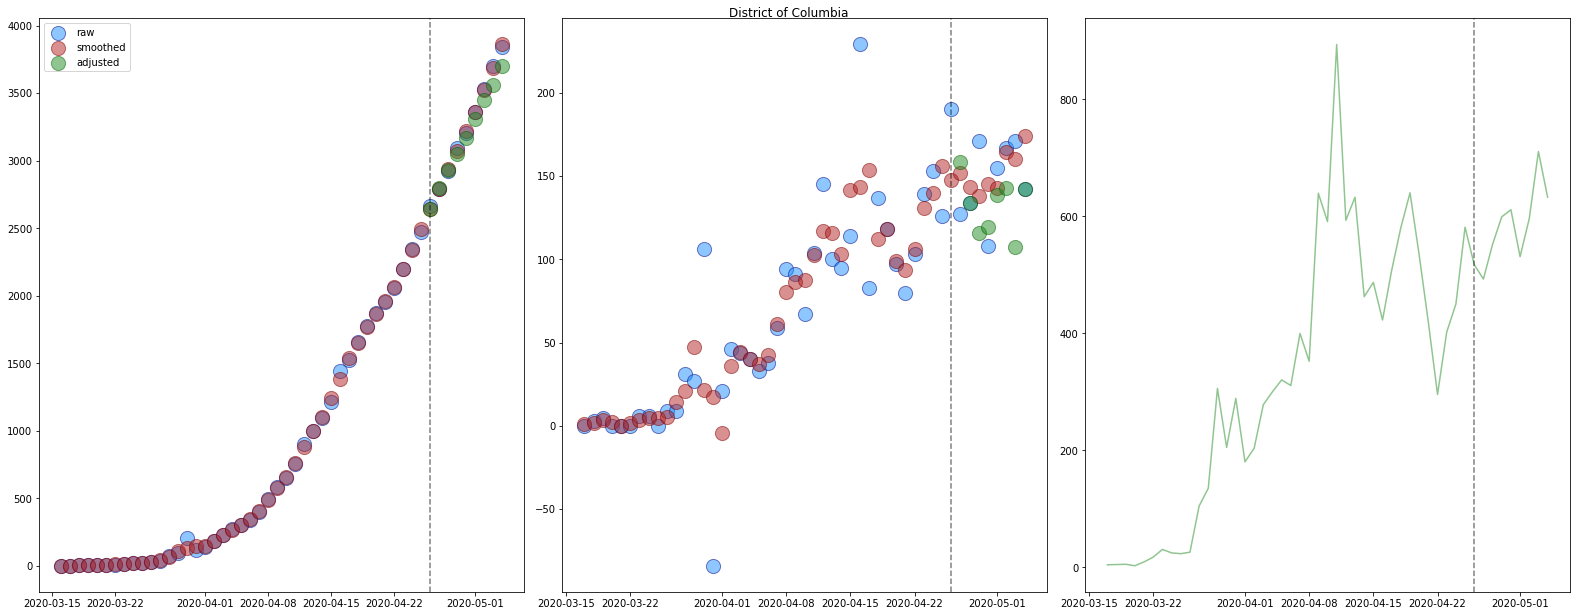

532


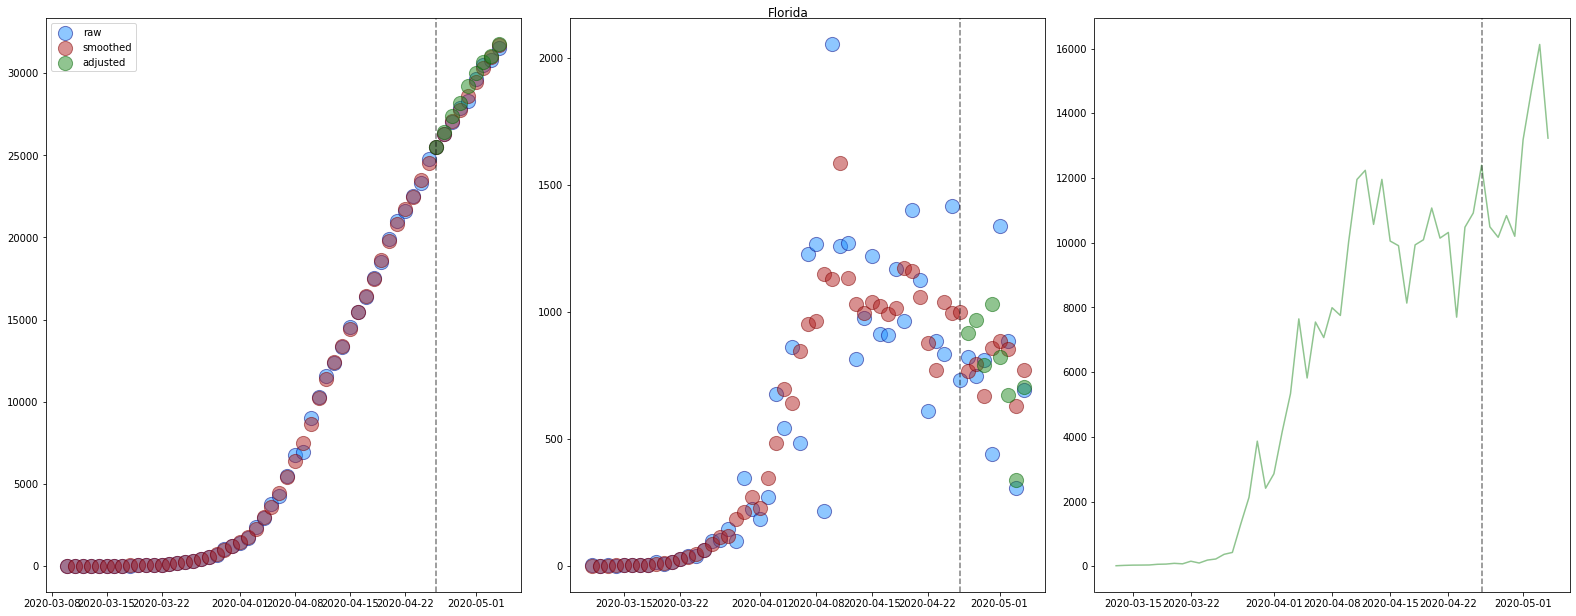

533


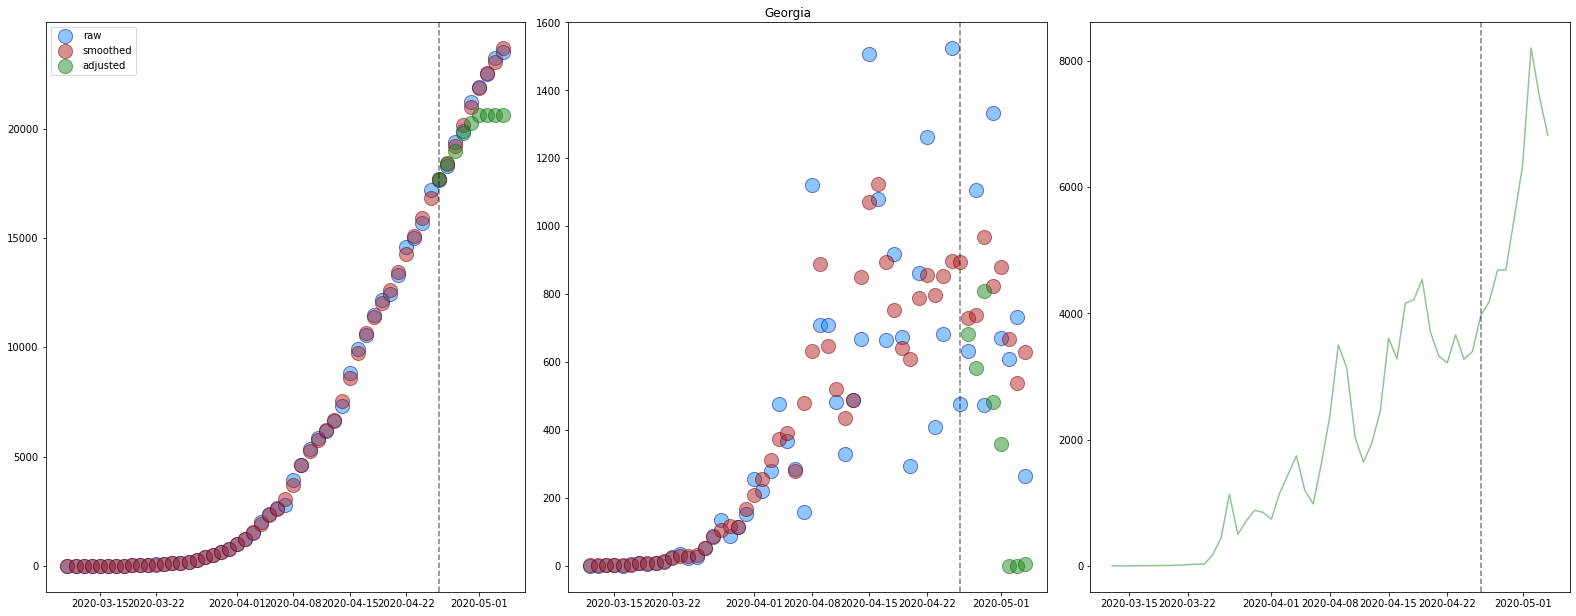

534


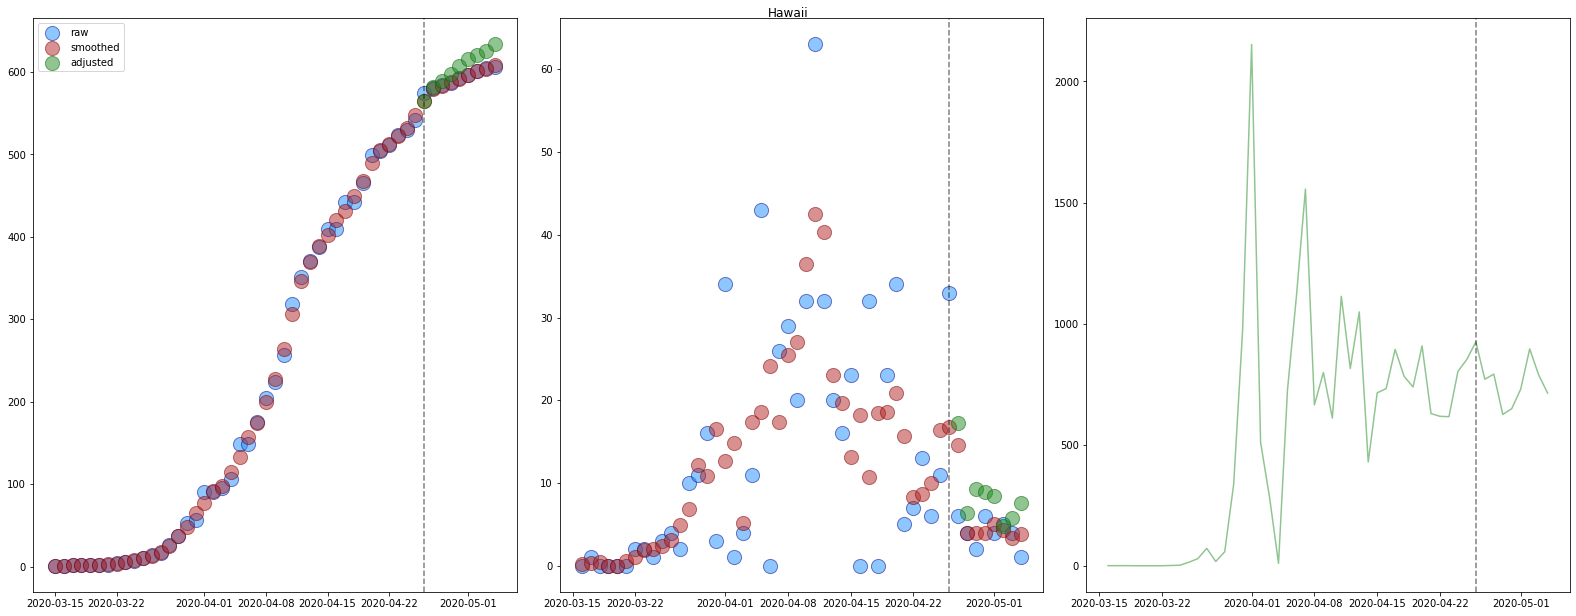

535


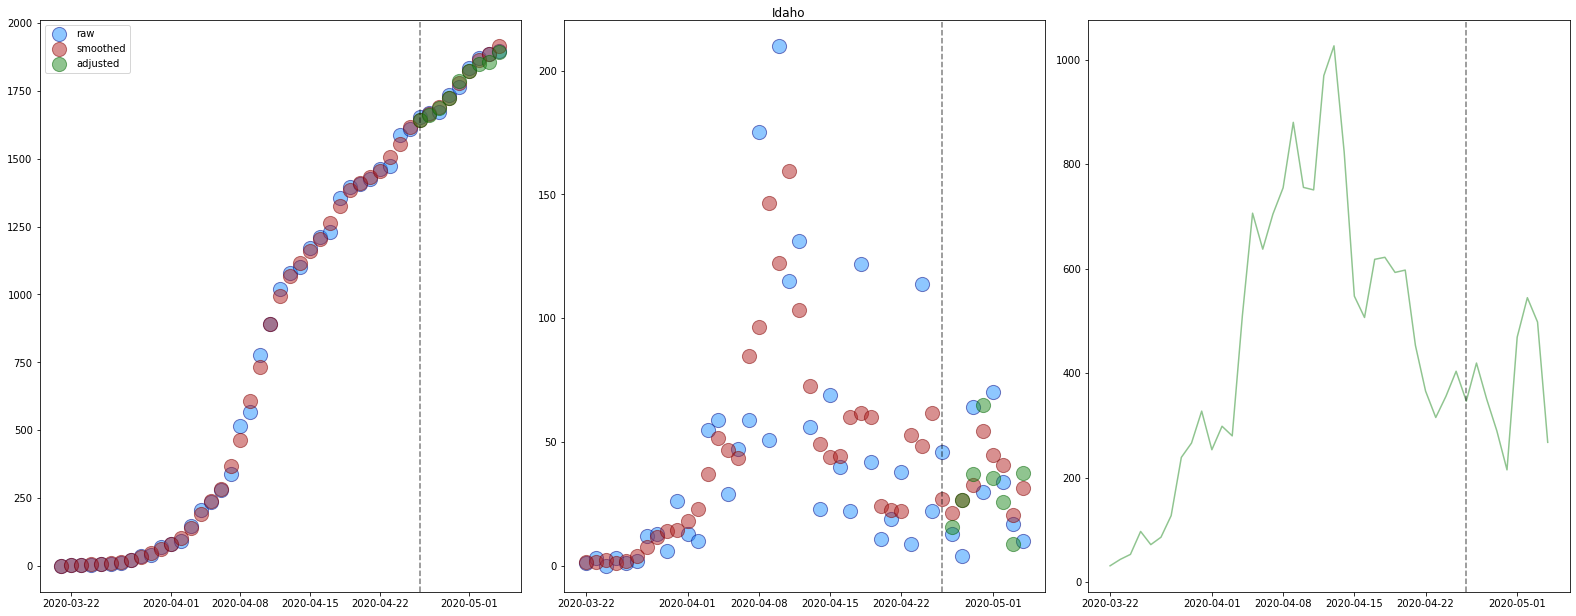

536


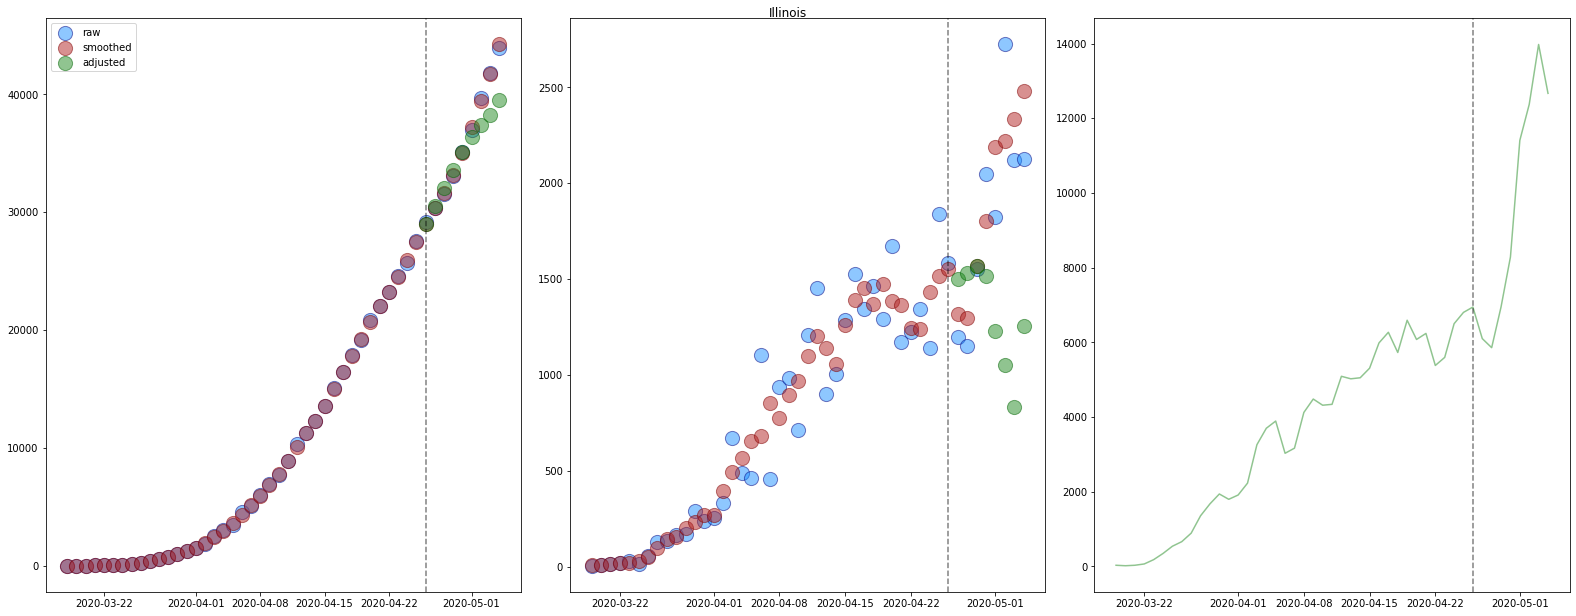

537


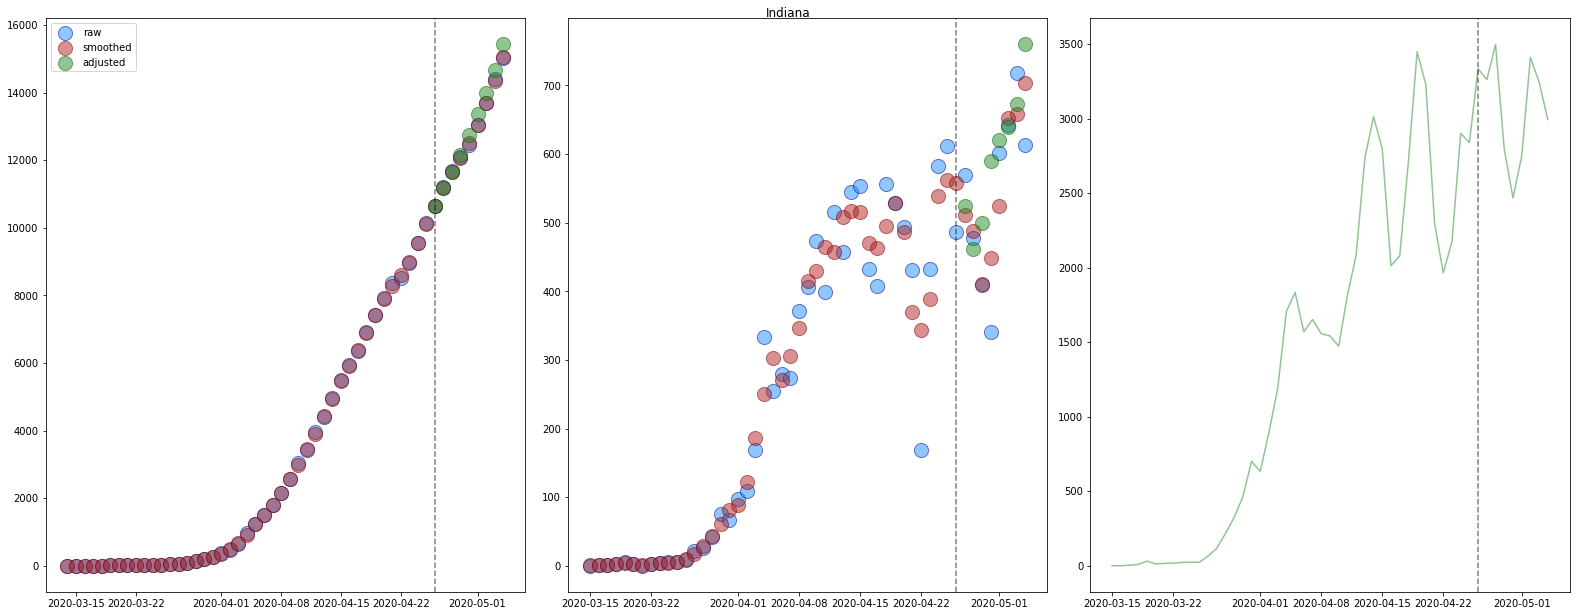

538


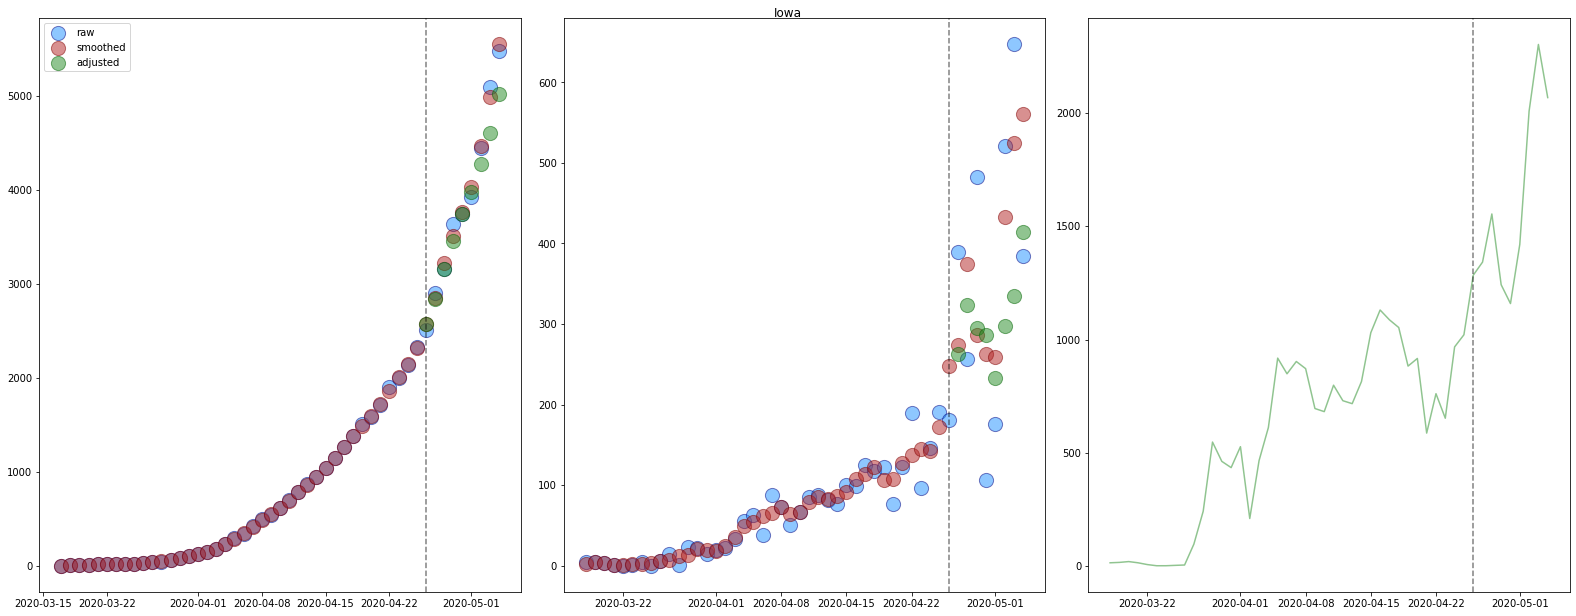

539


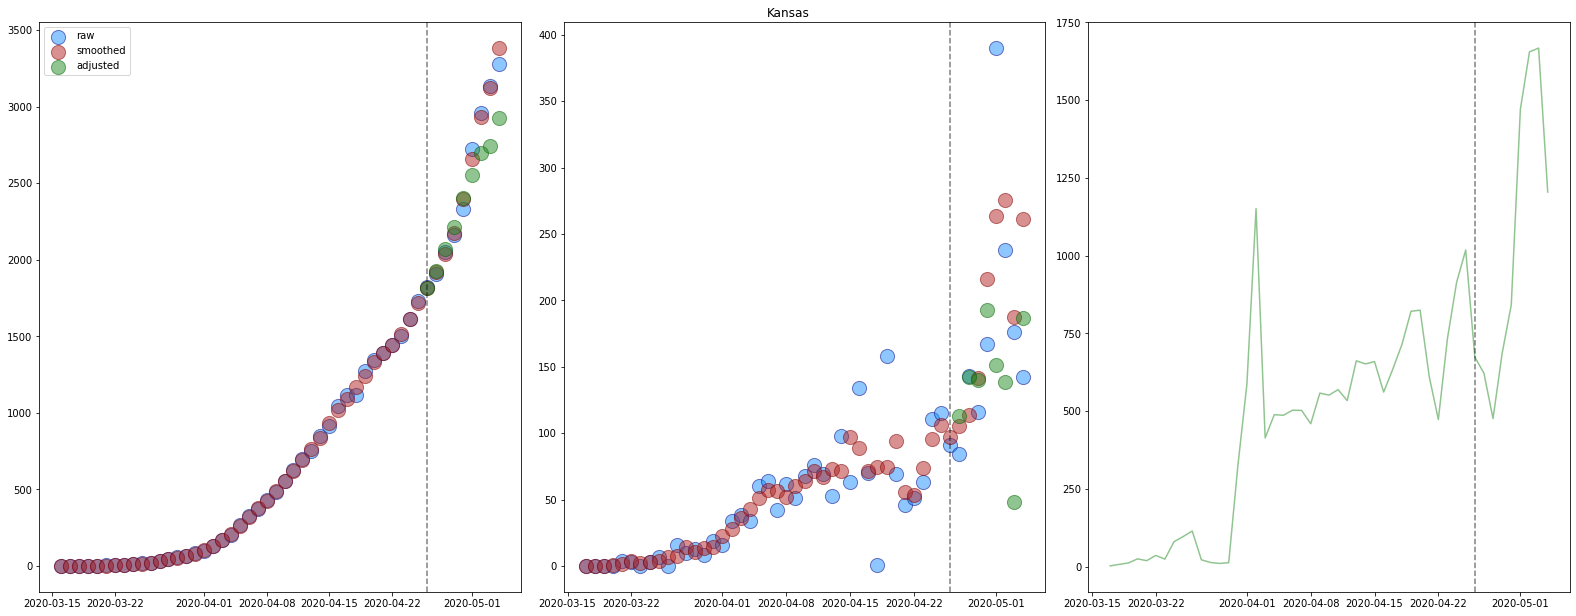

540


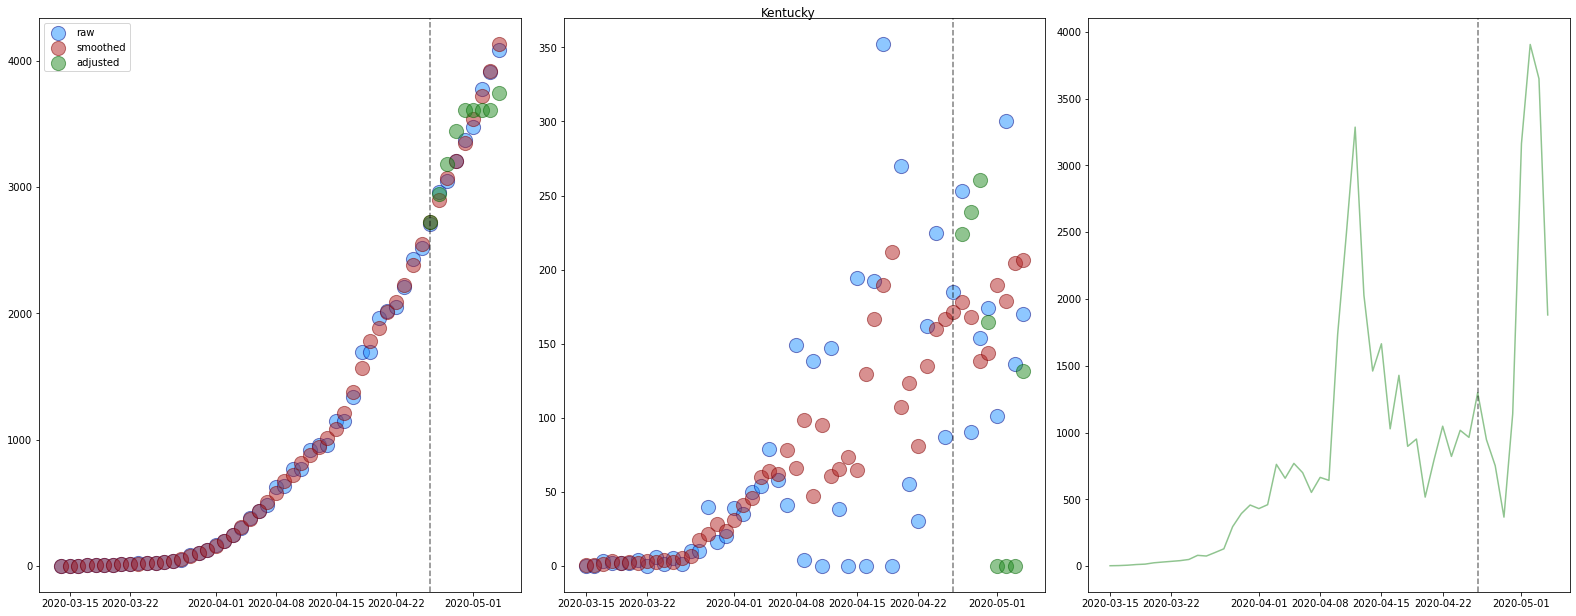

541


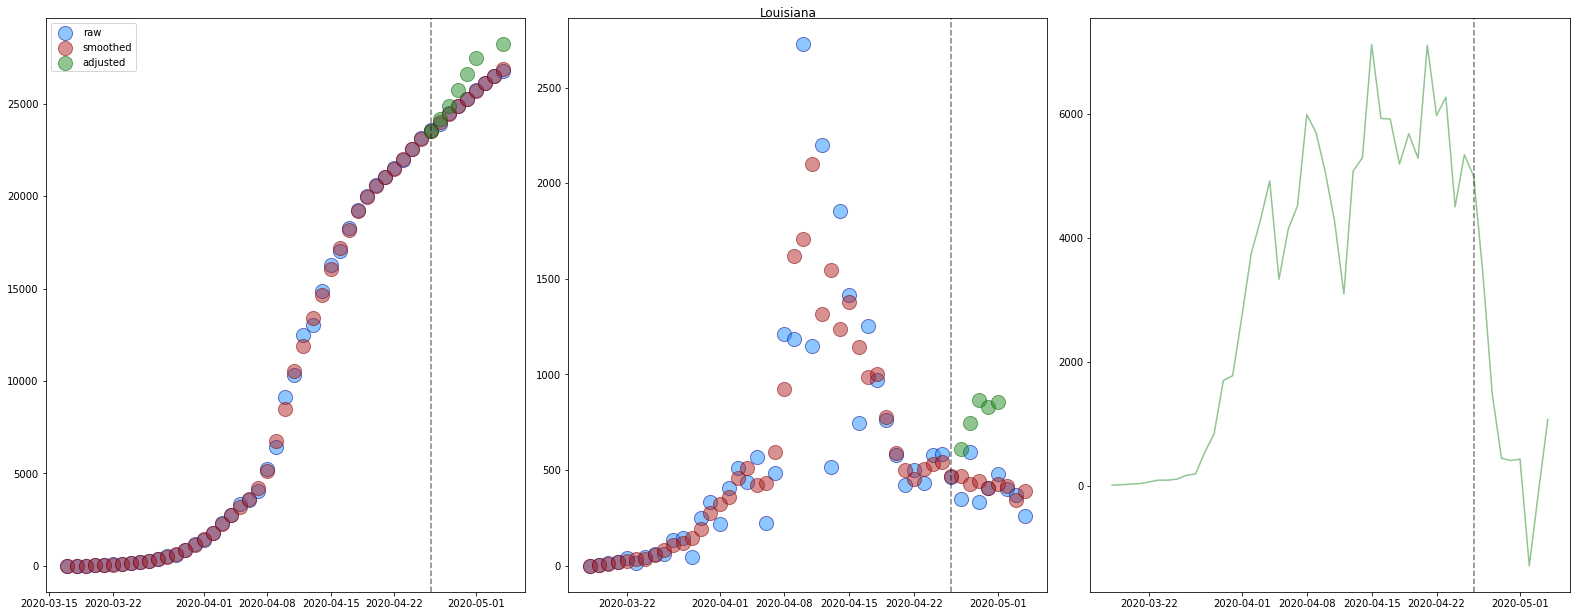

542


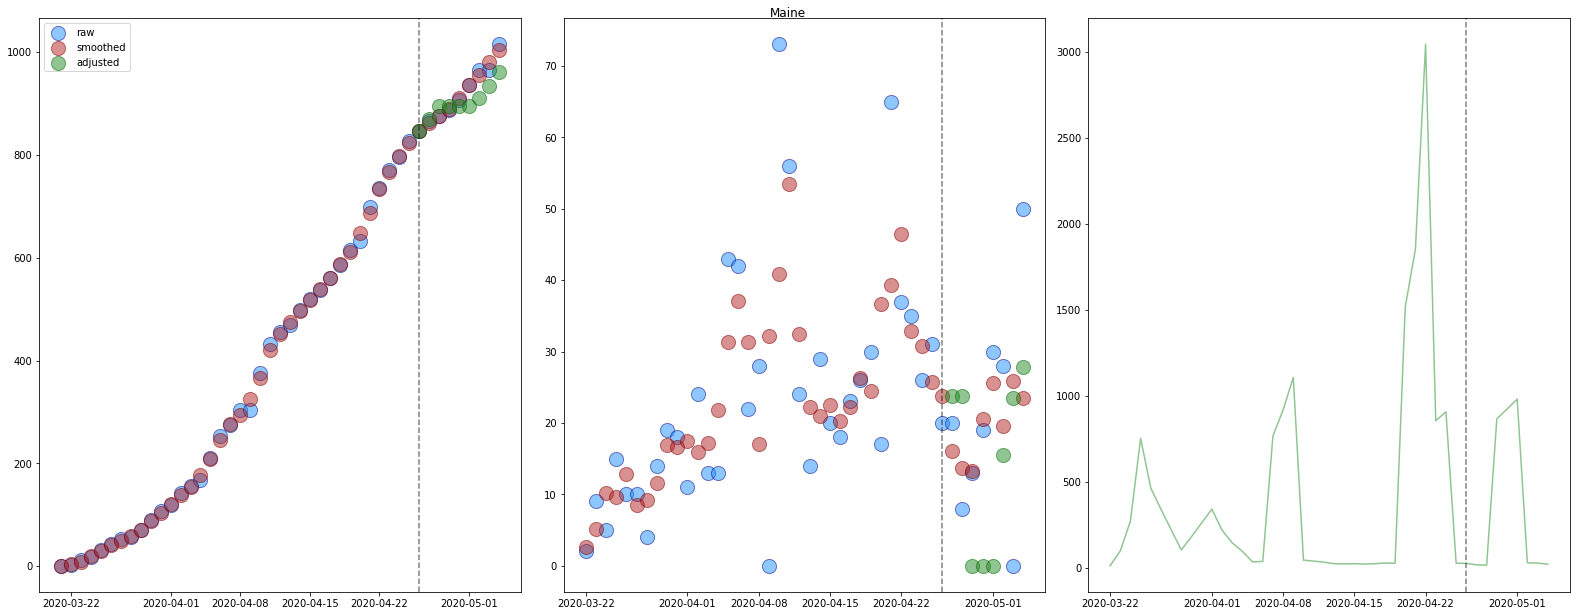

543


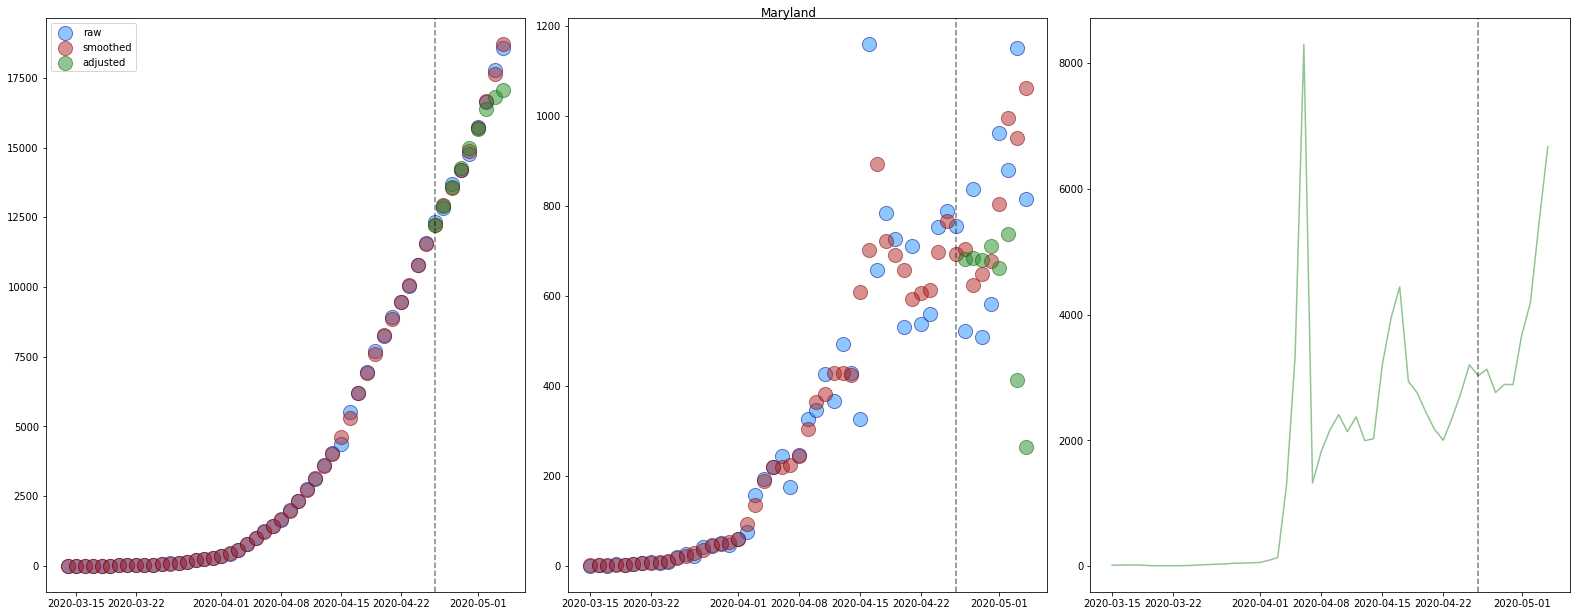

544


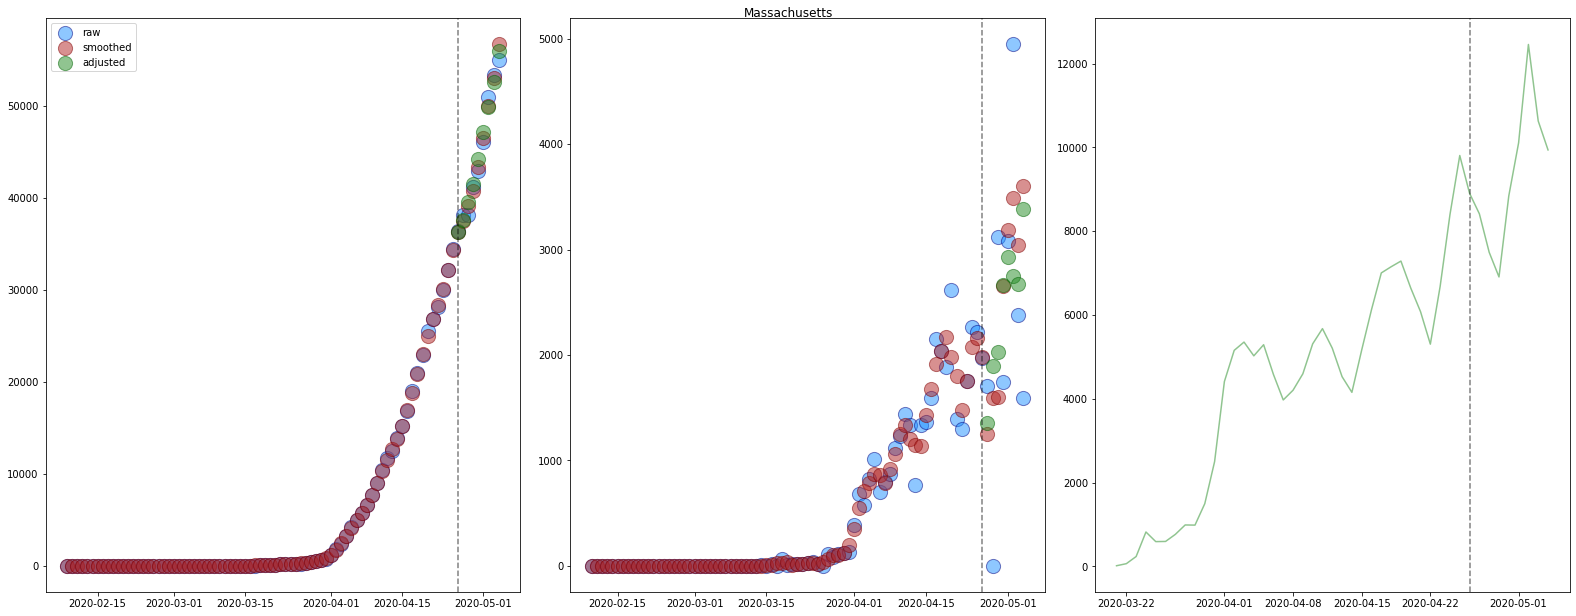

545


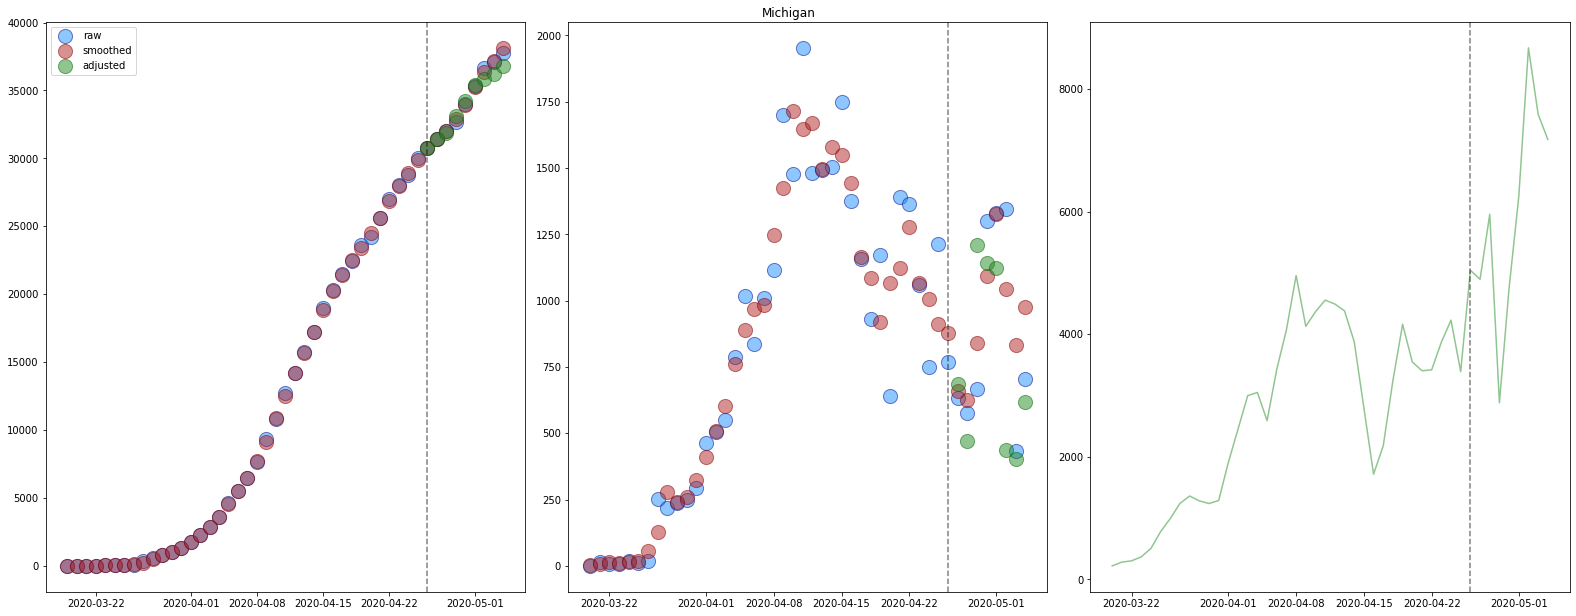

546


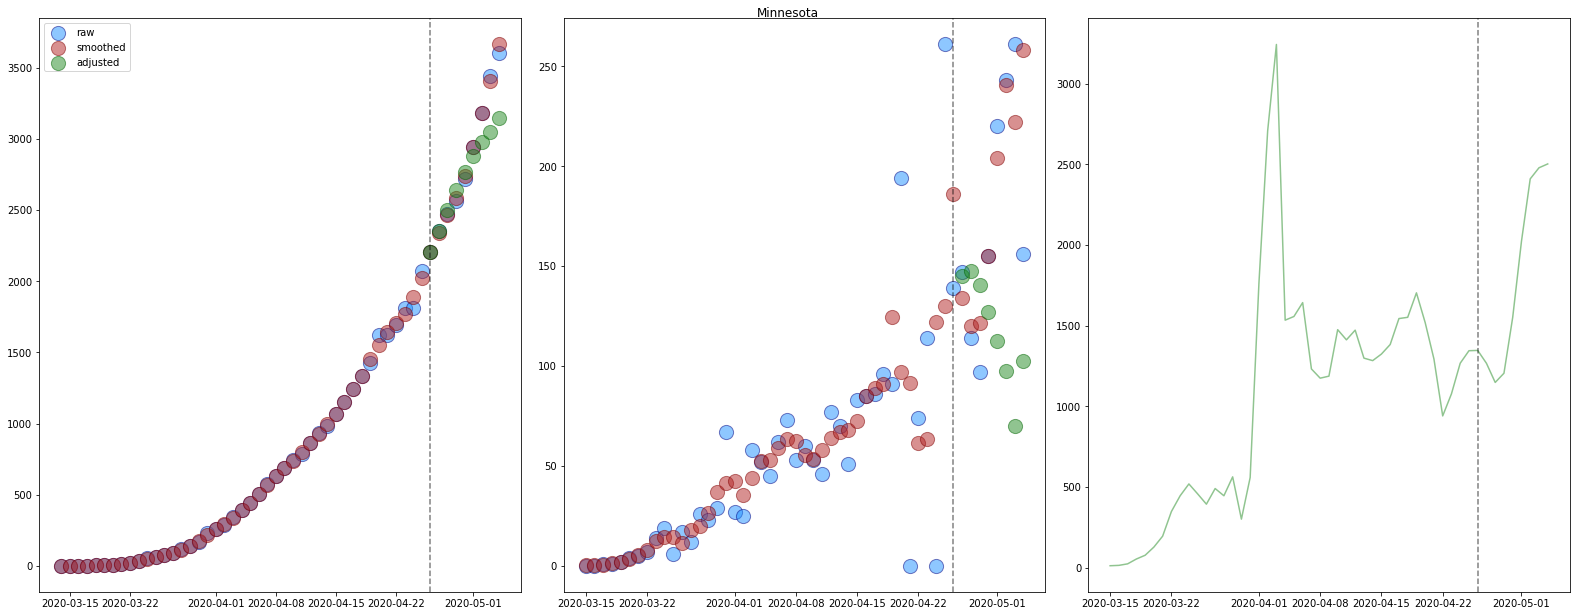

547


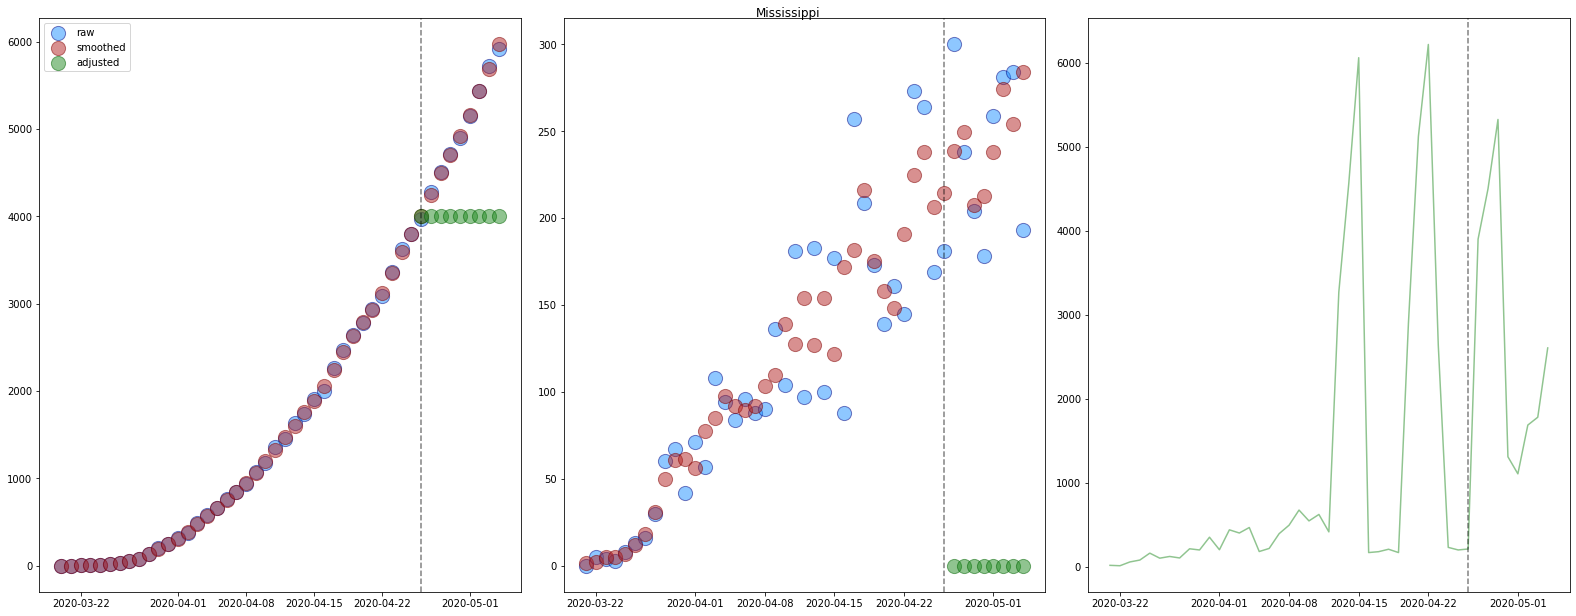

548


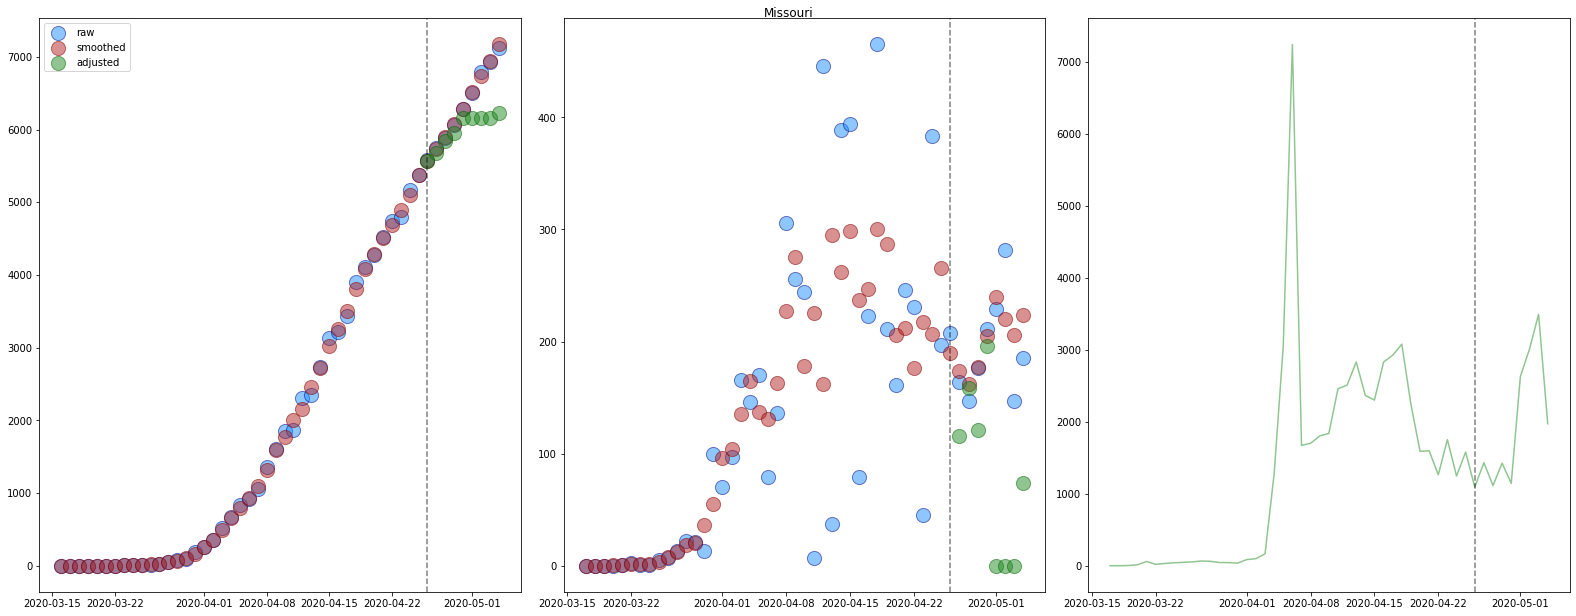

549


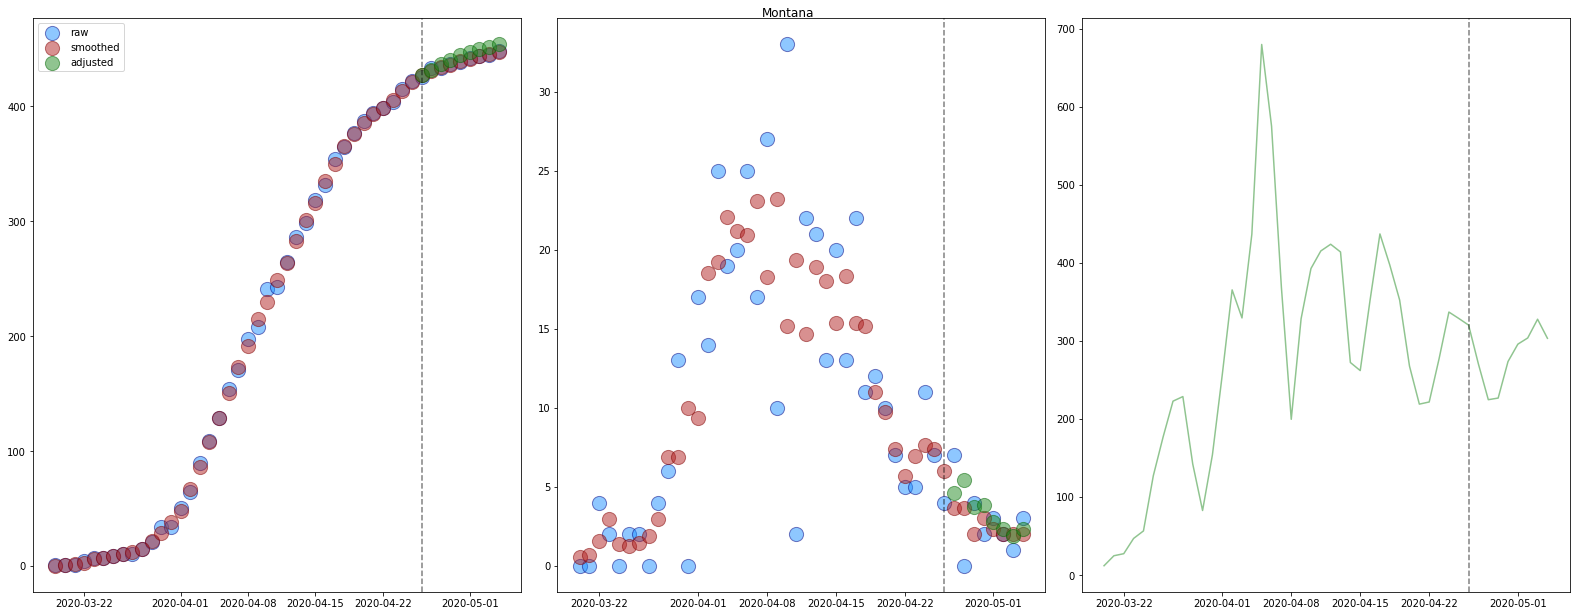

550


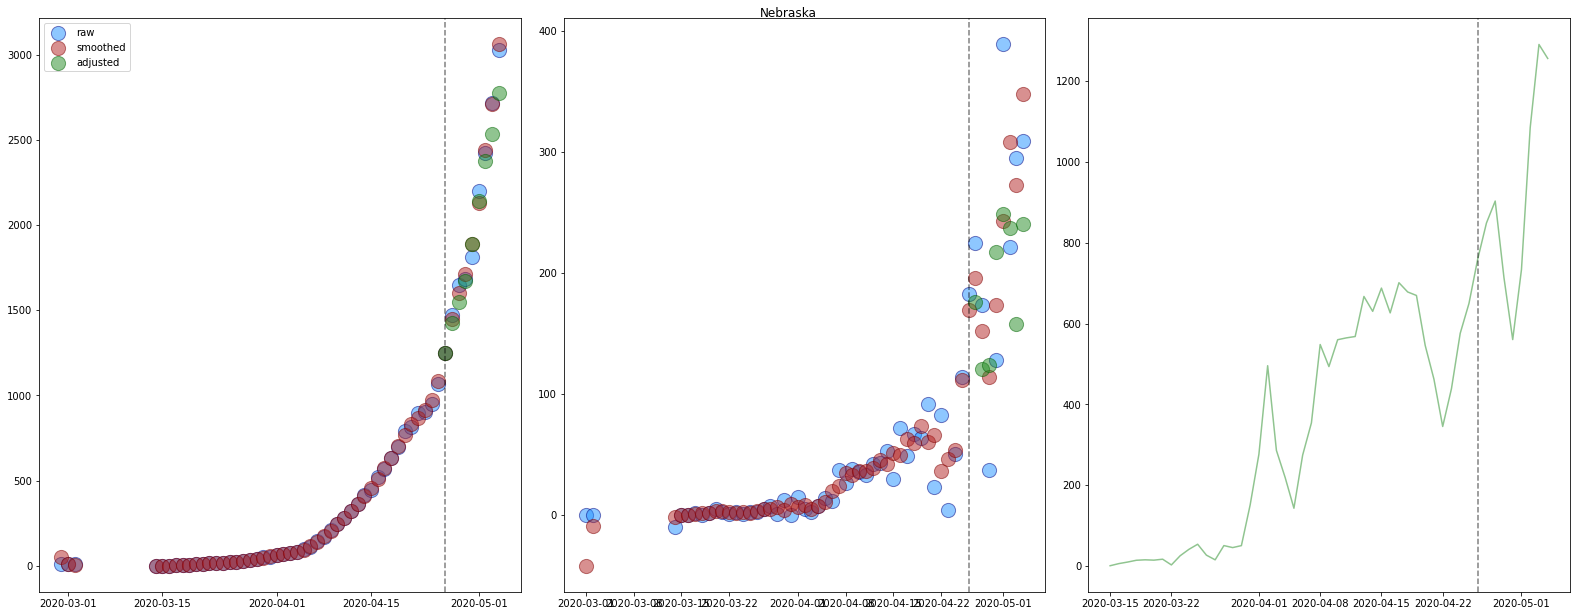

551


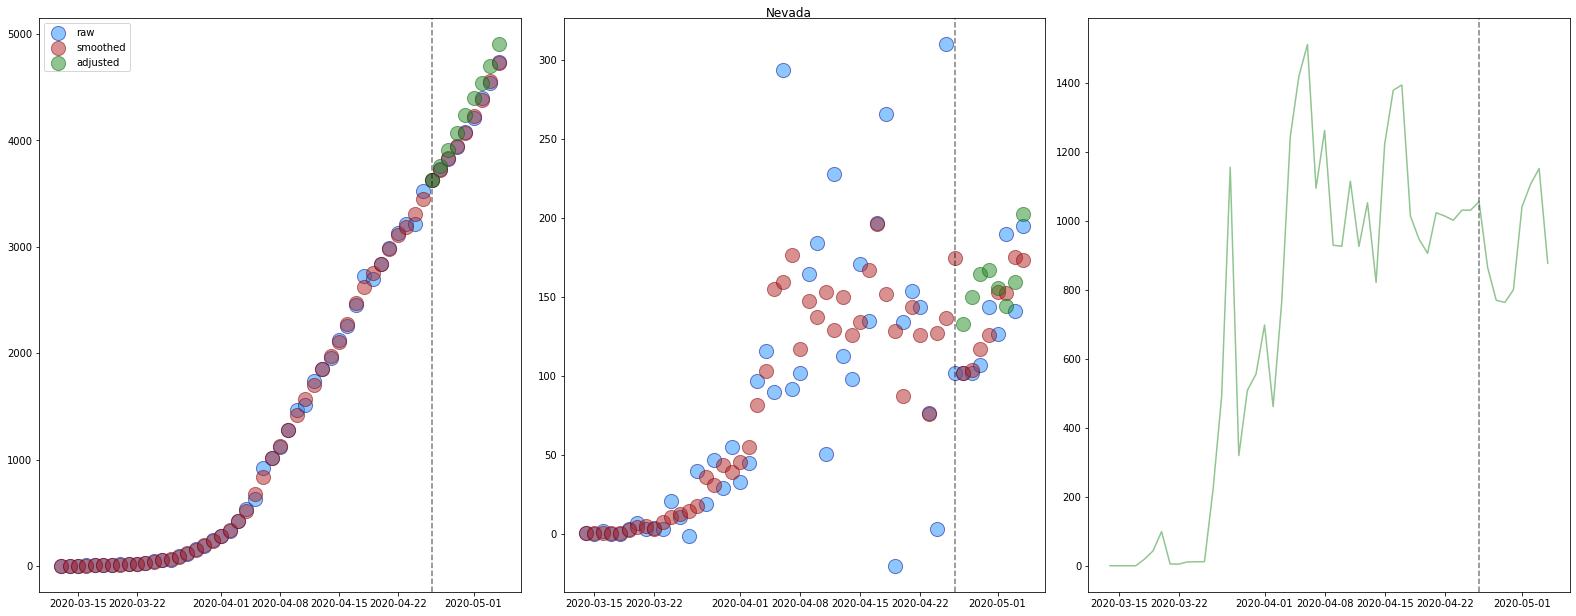

552


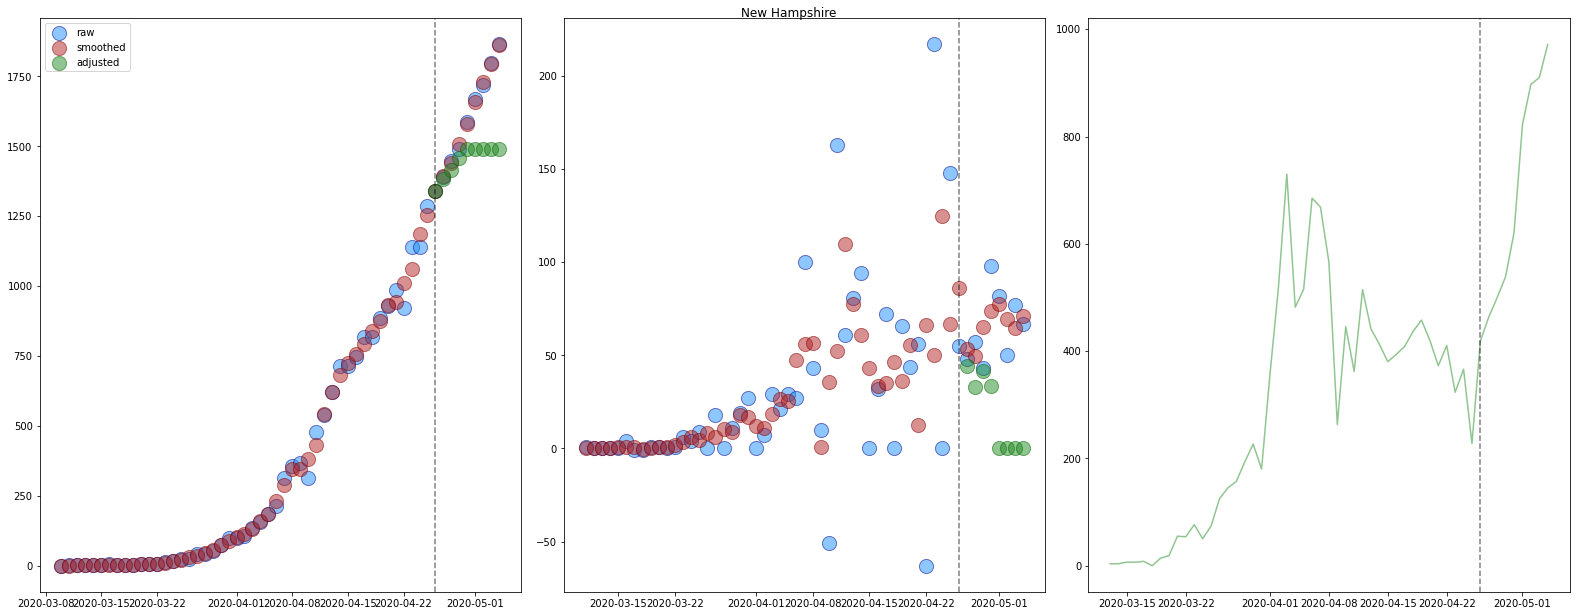

553


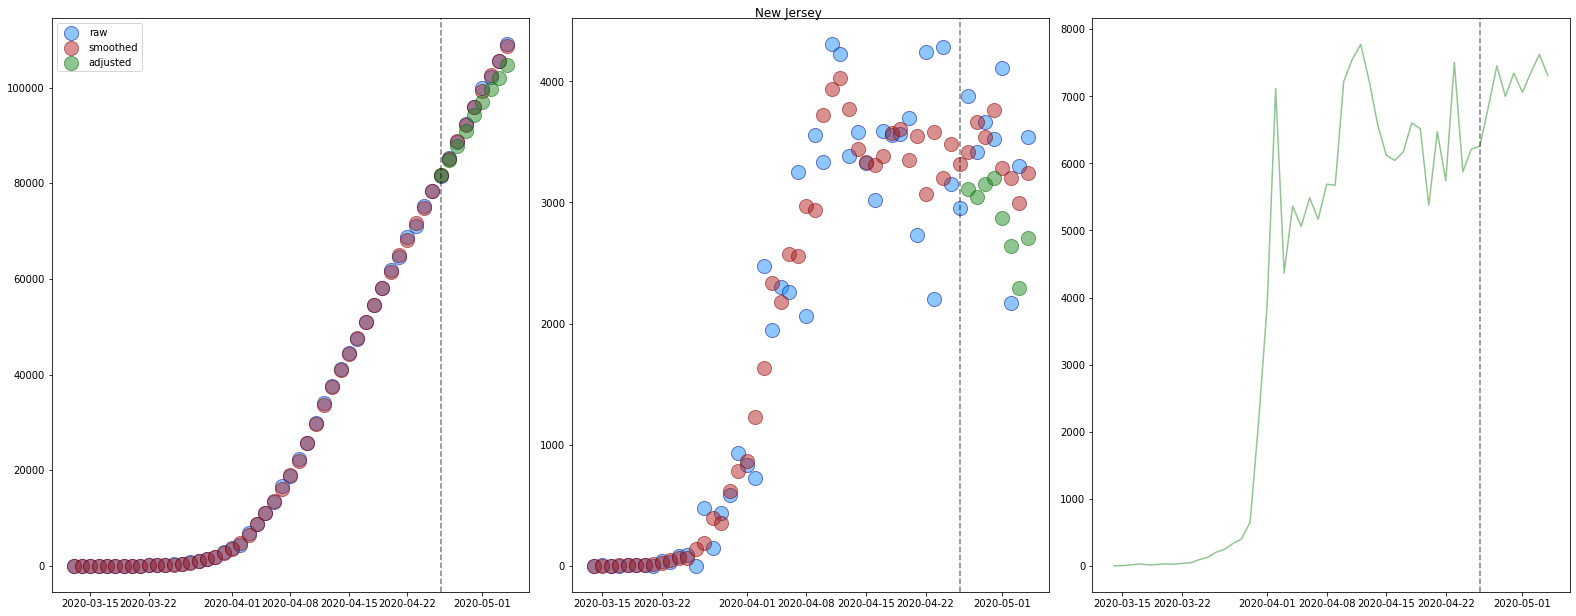

554


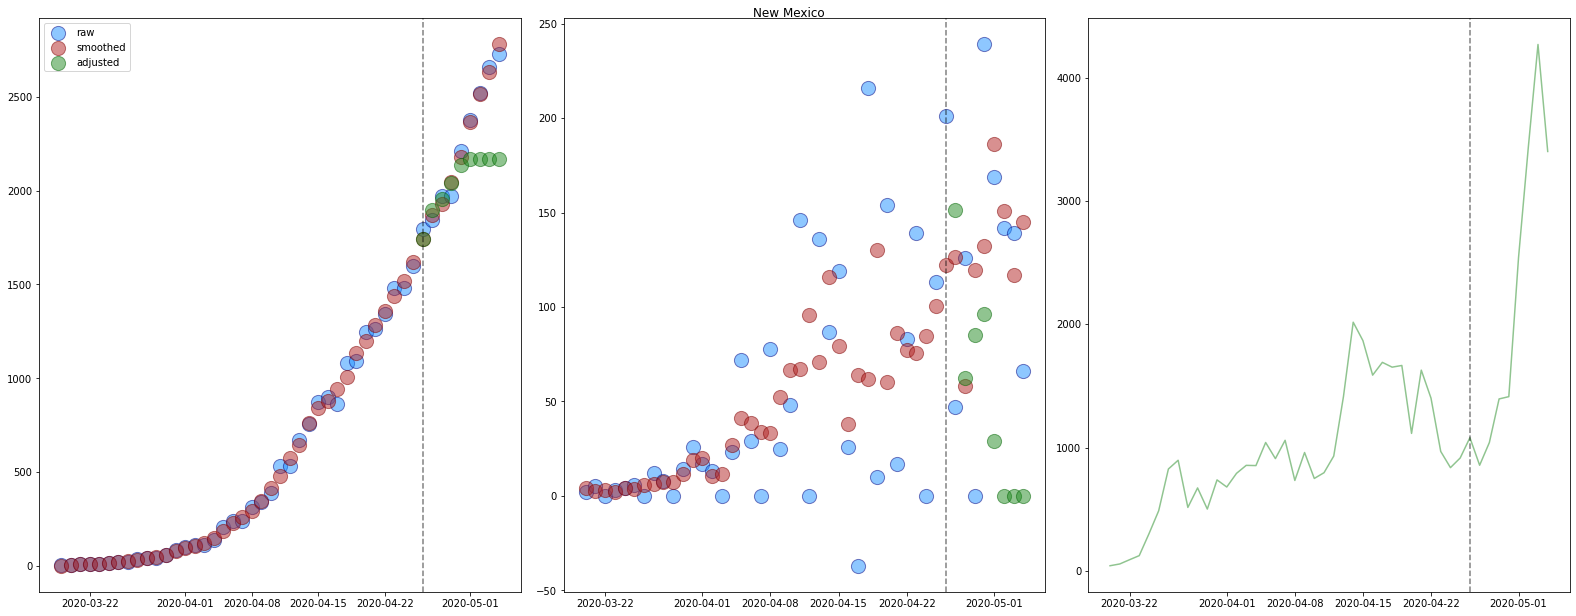

555


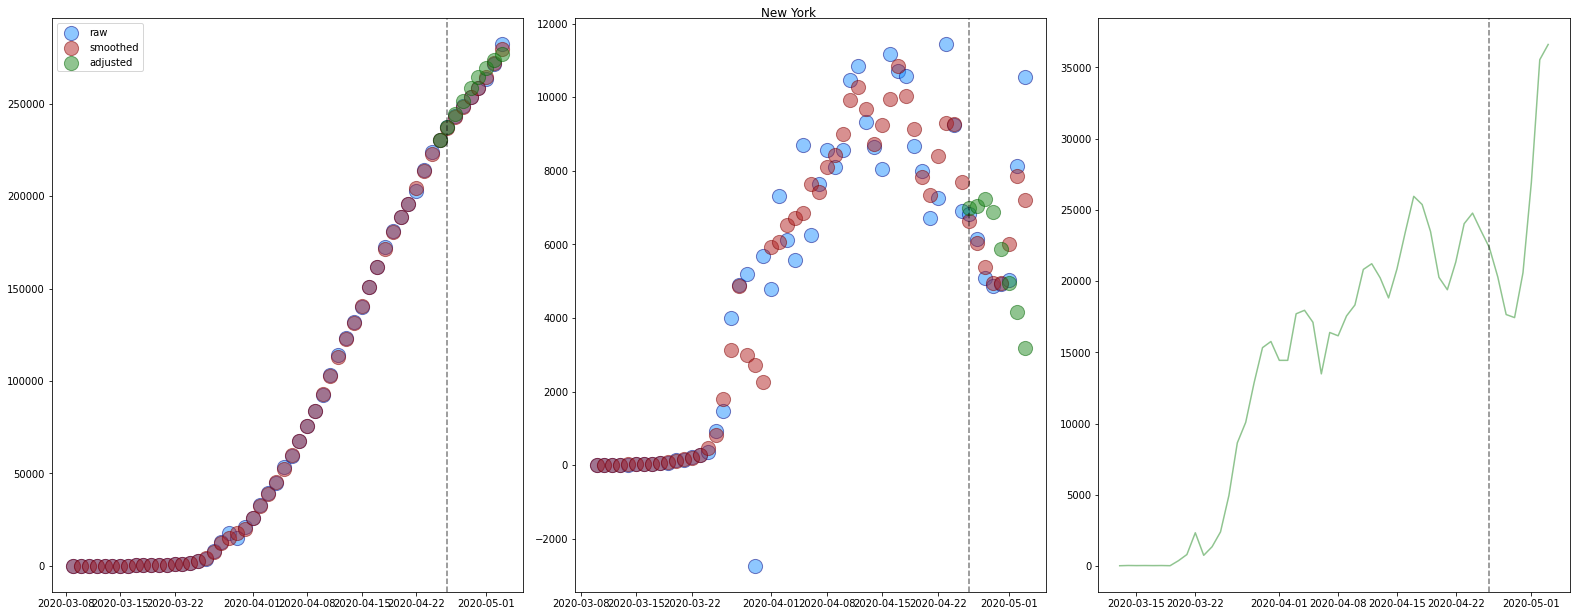

556


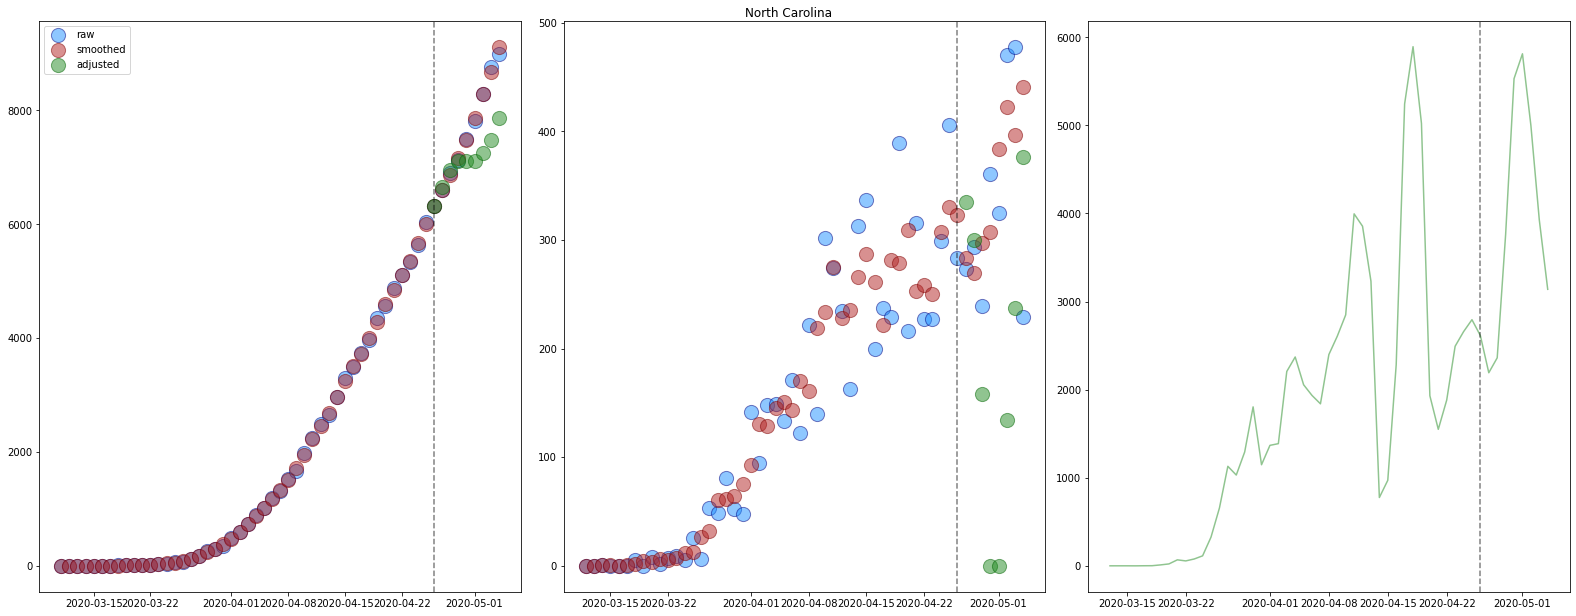

557


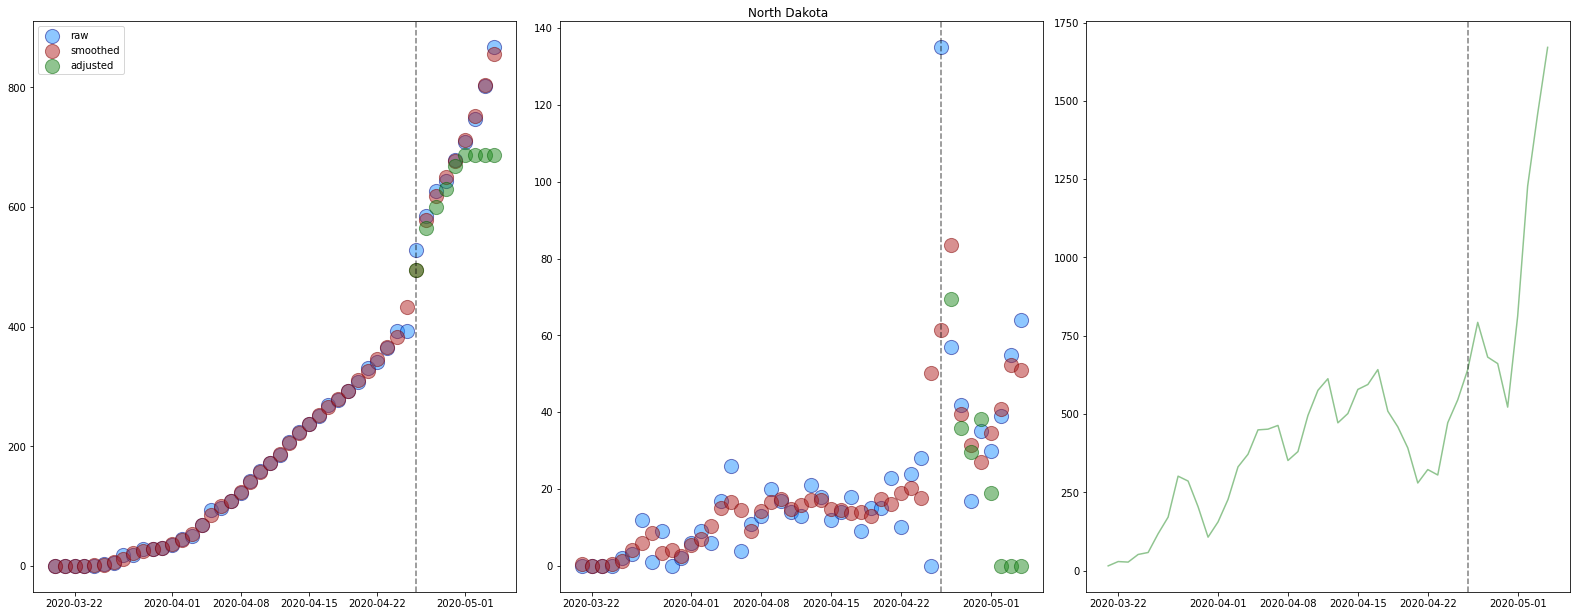

558


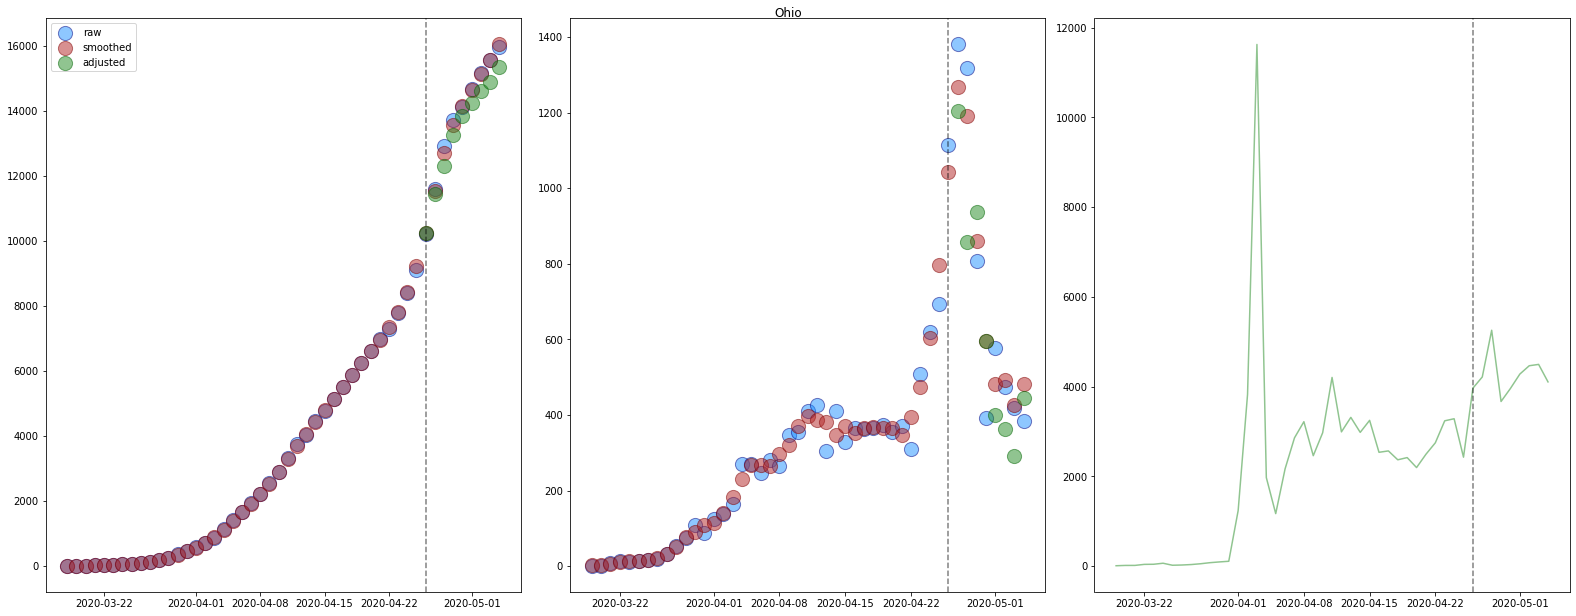

559


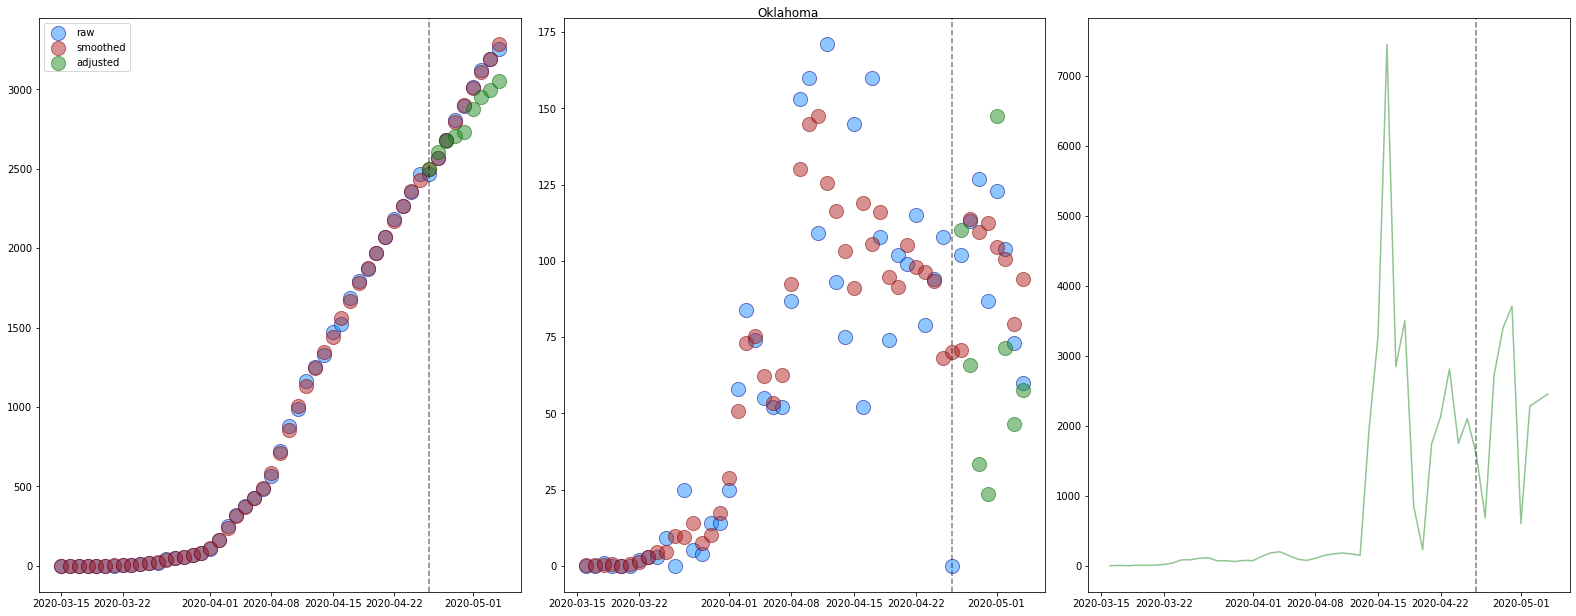

560


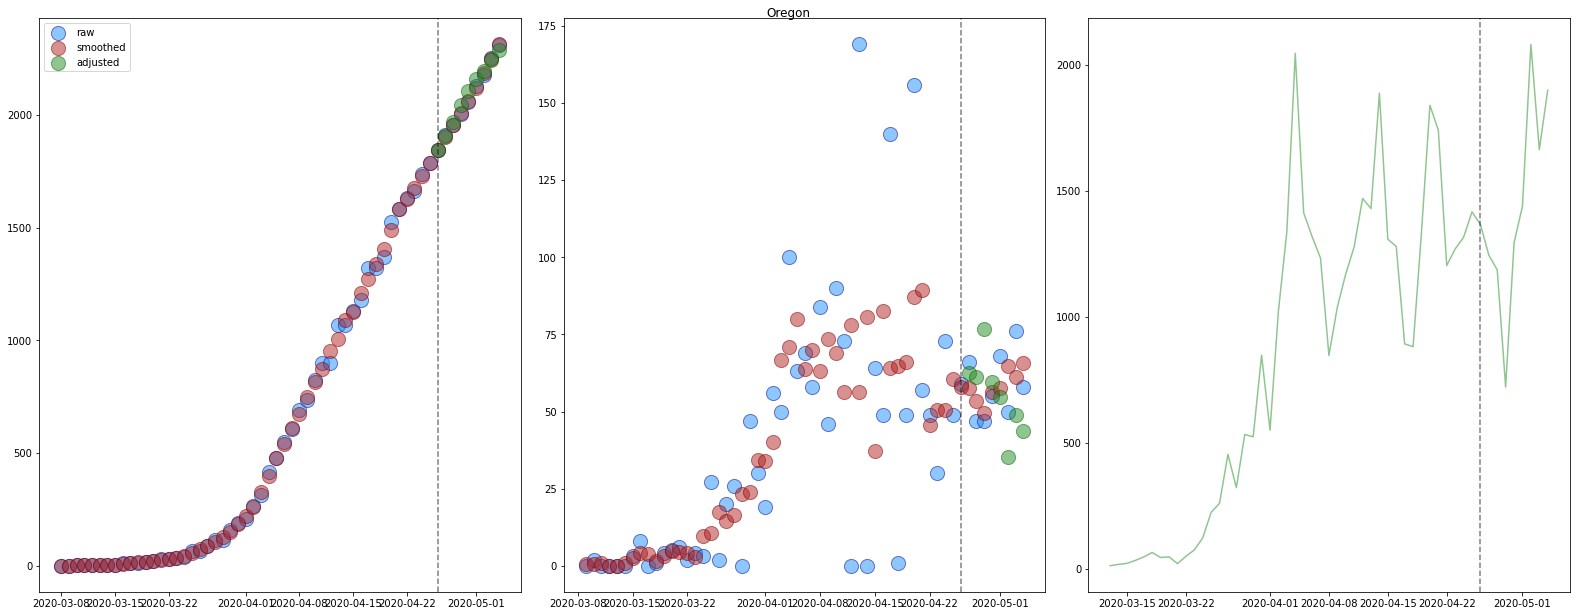

561


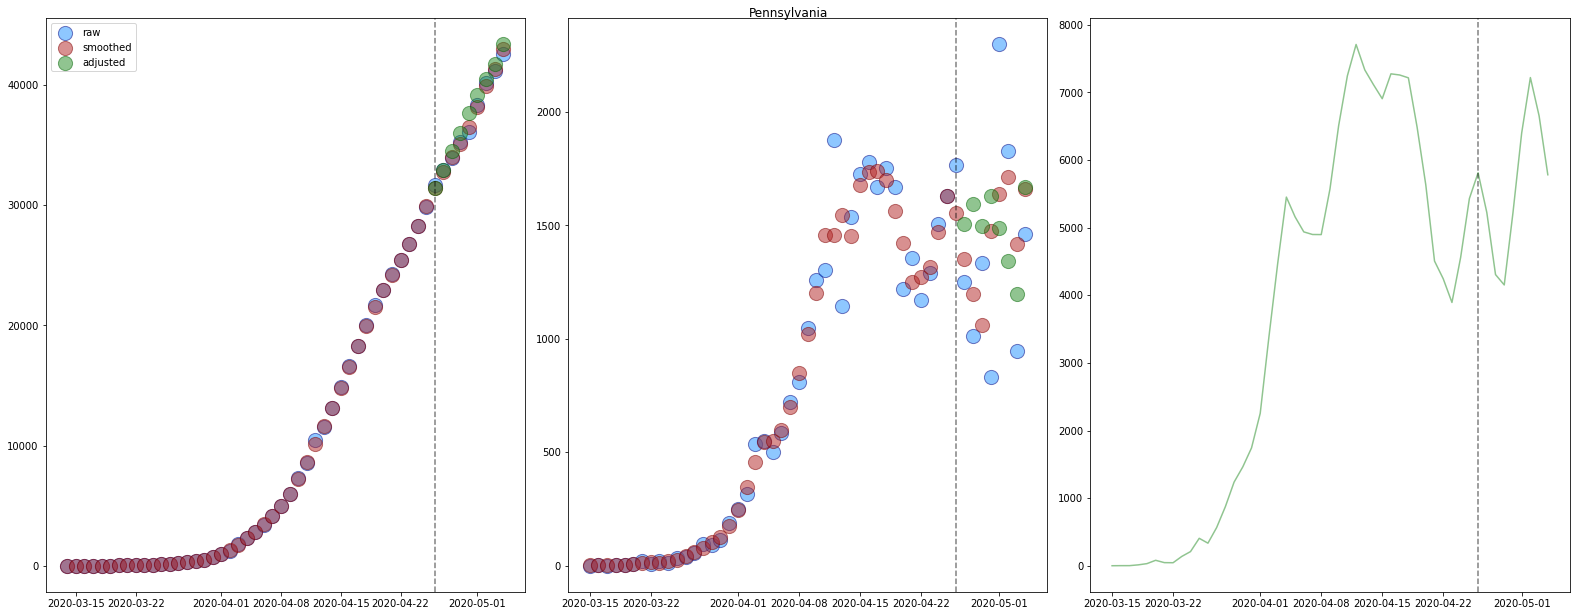

562


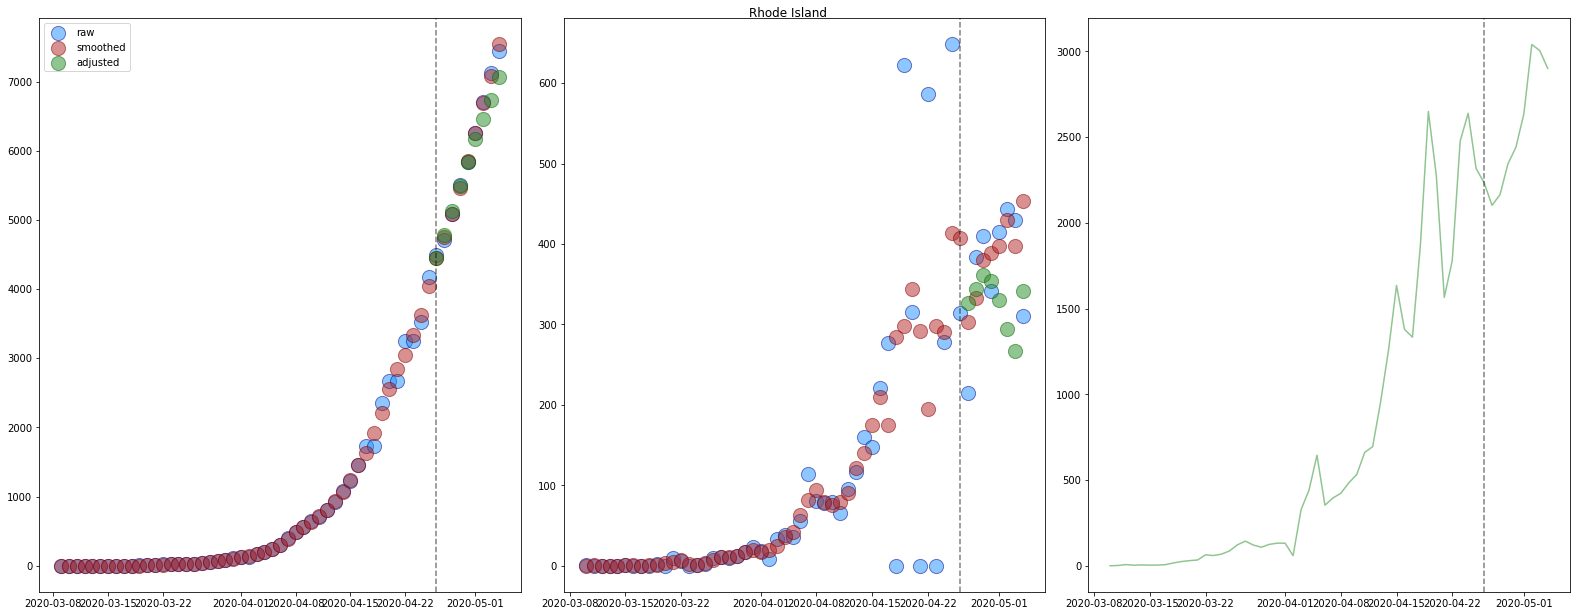

563


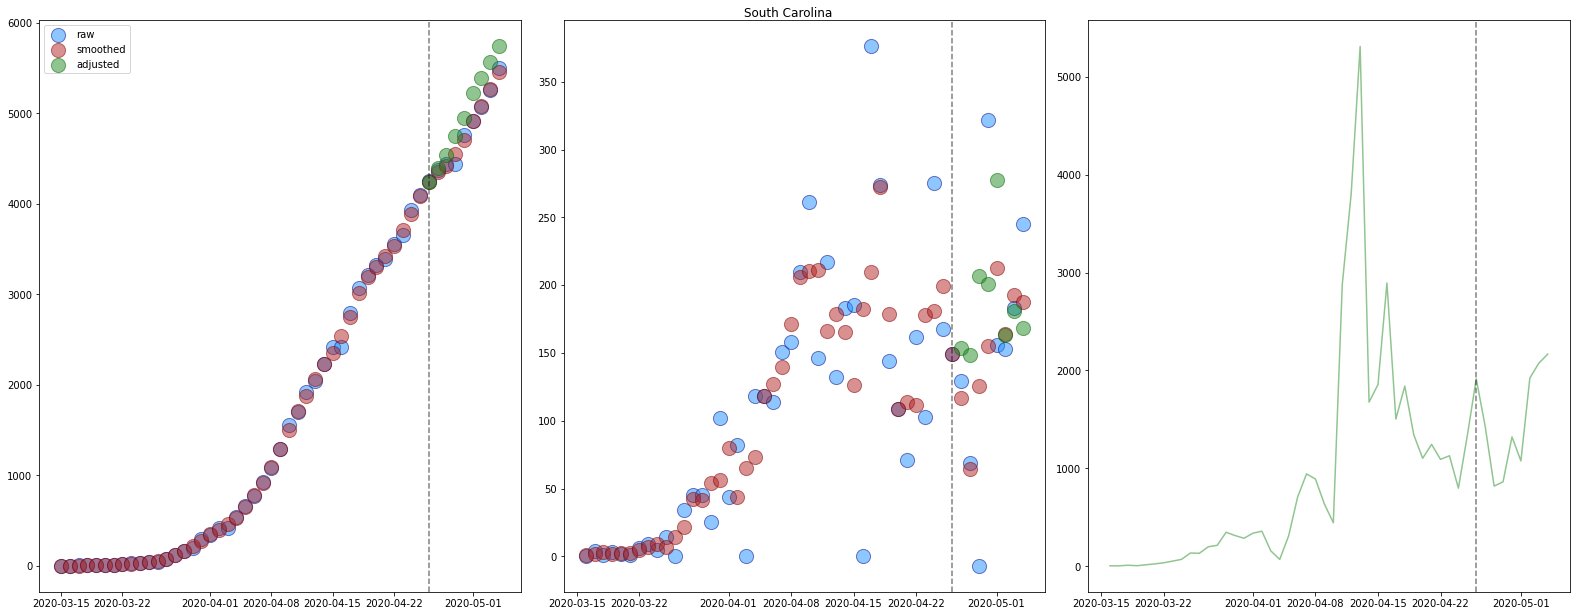

564


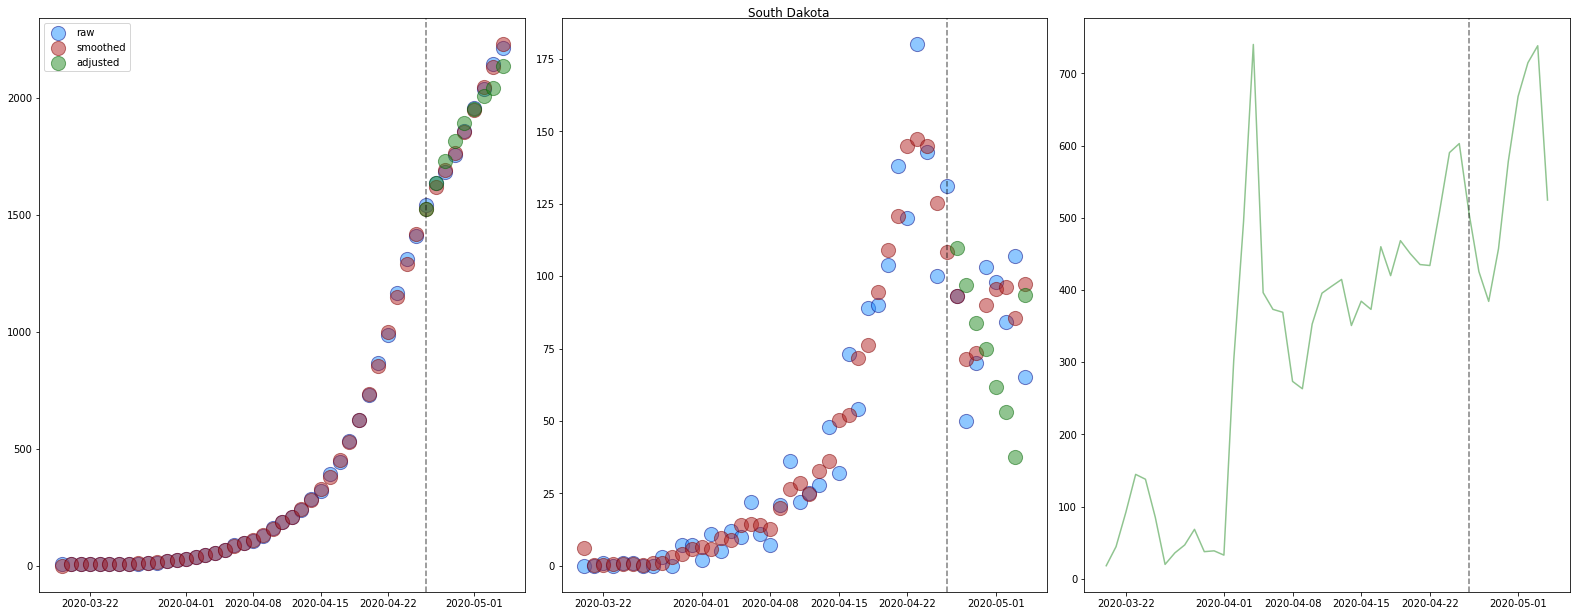

565


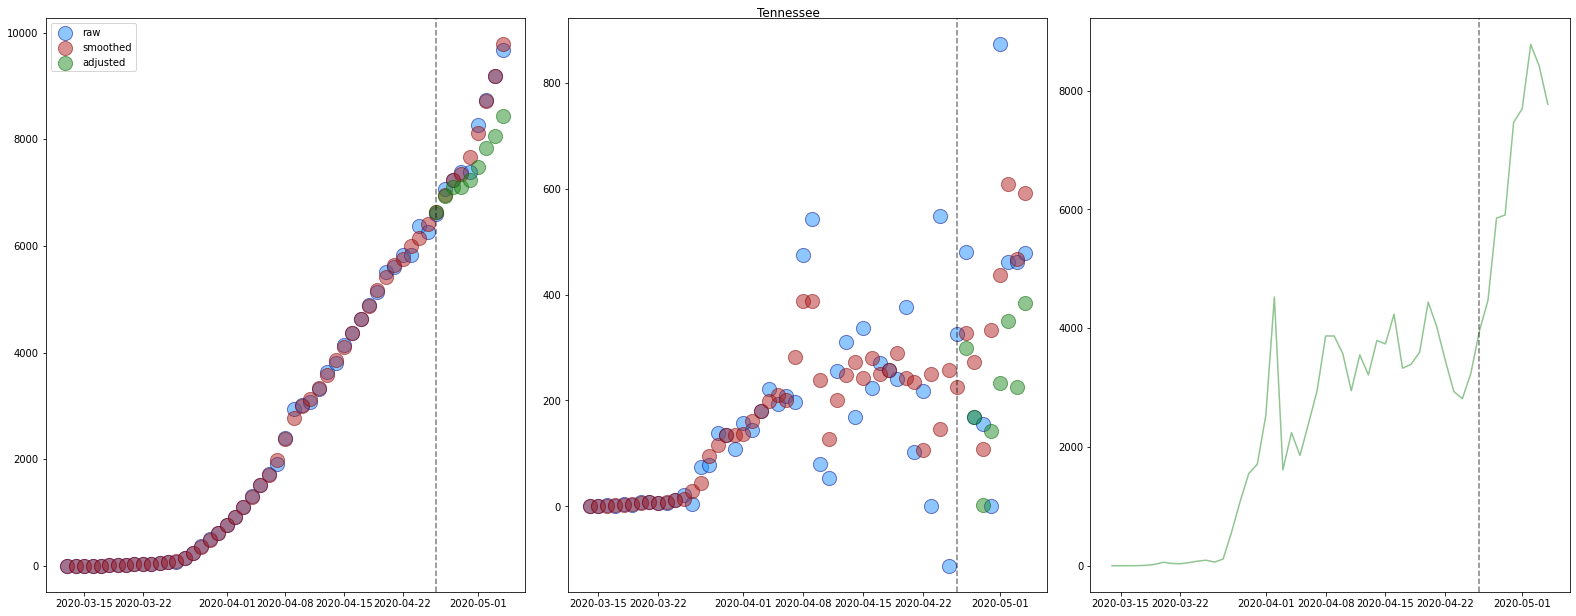

566


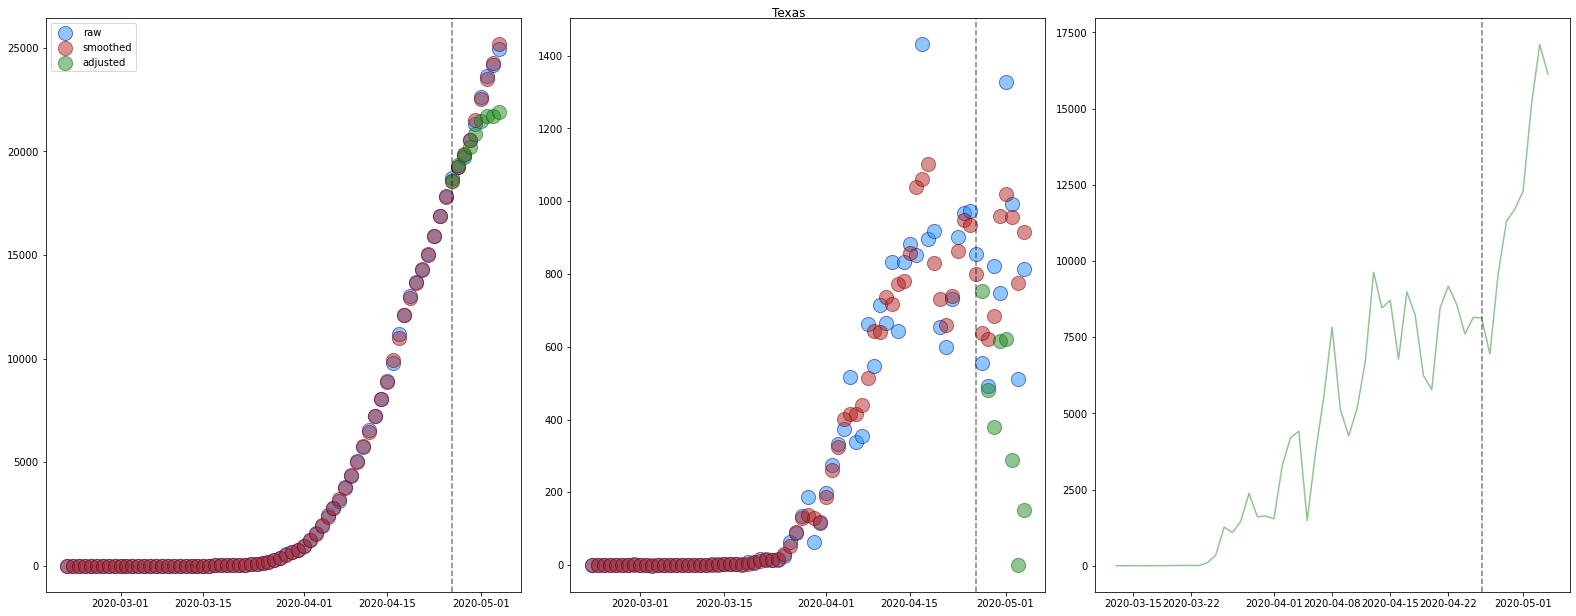

567


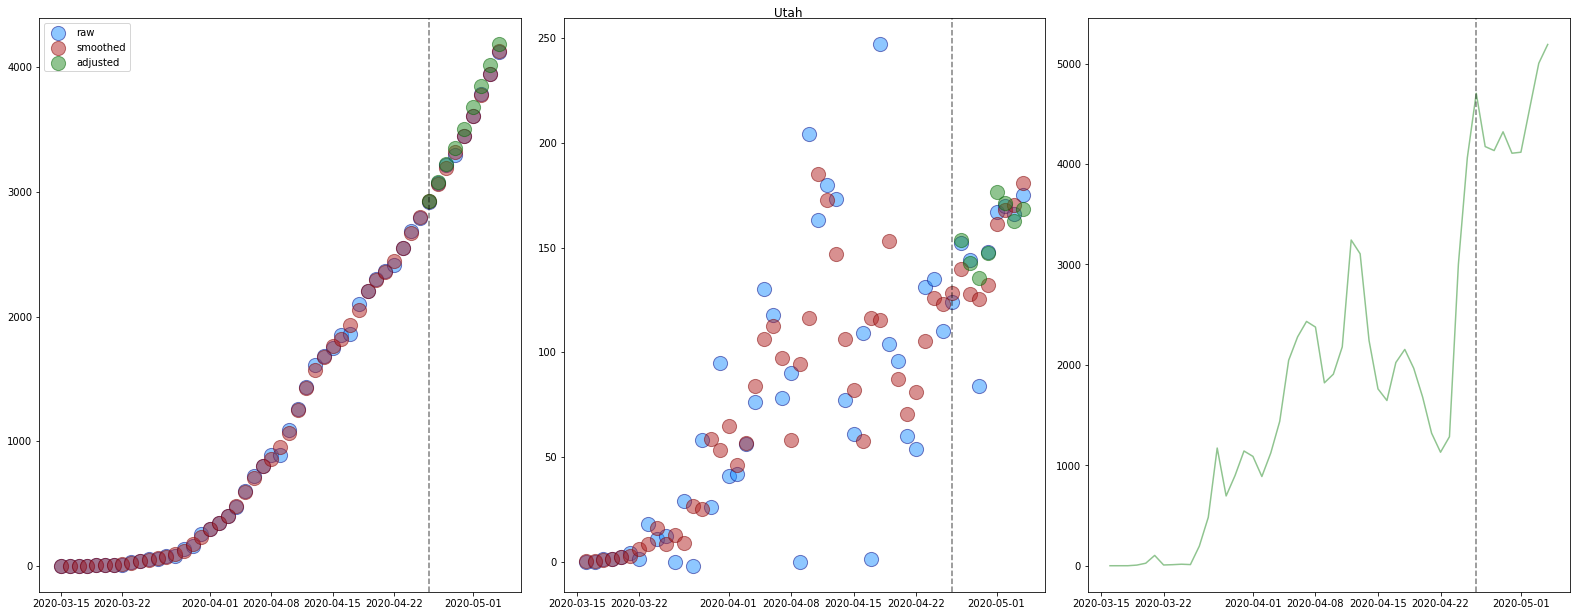

568


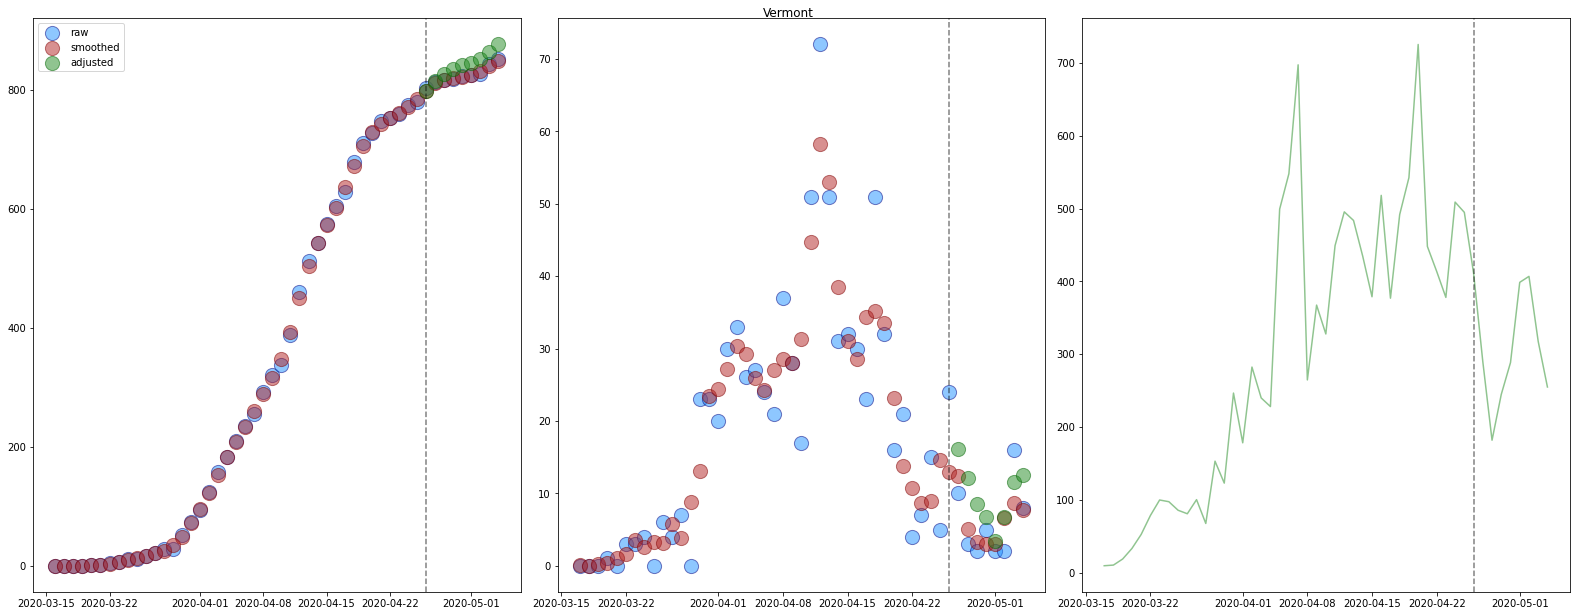

569


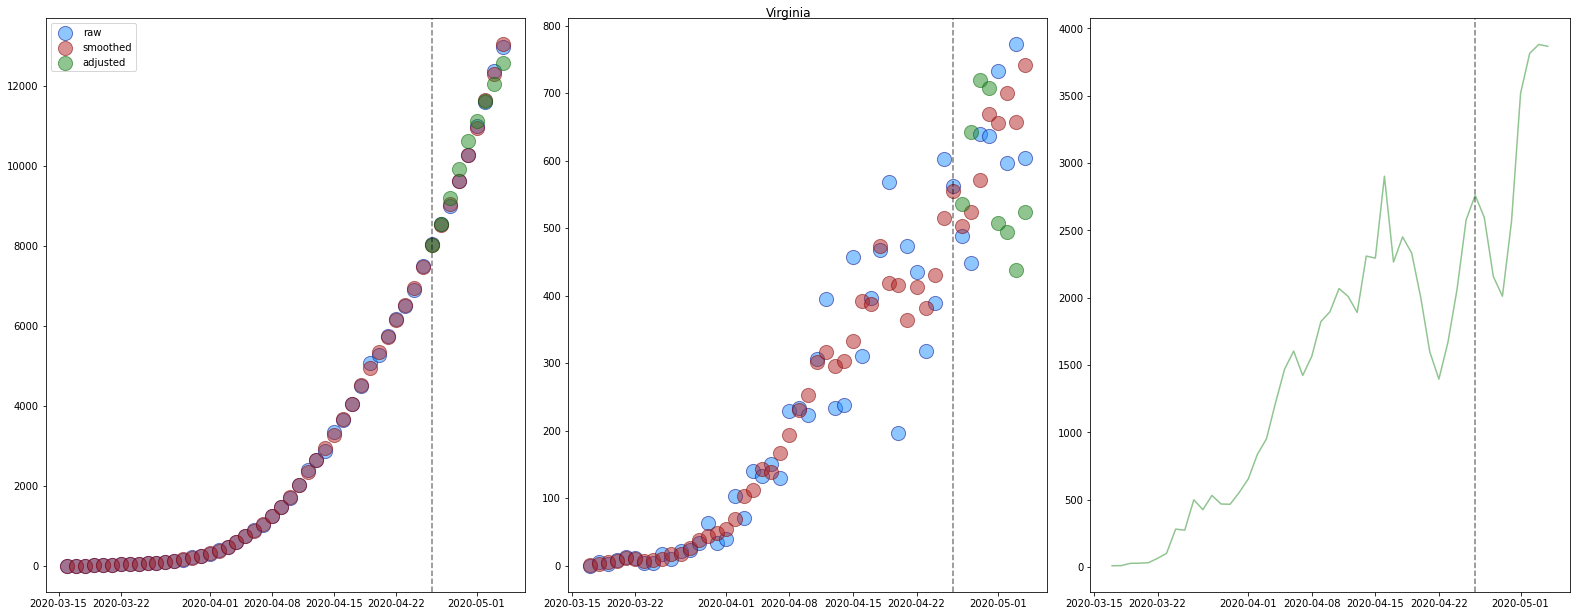

571


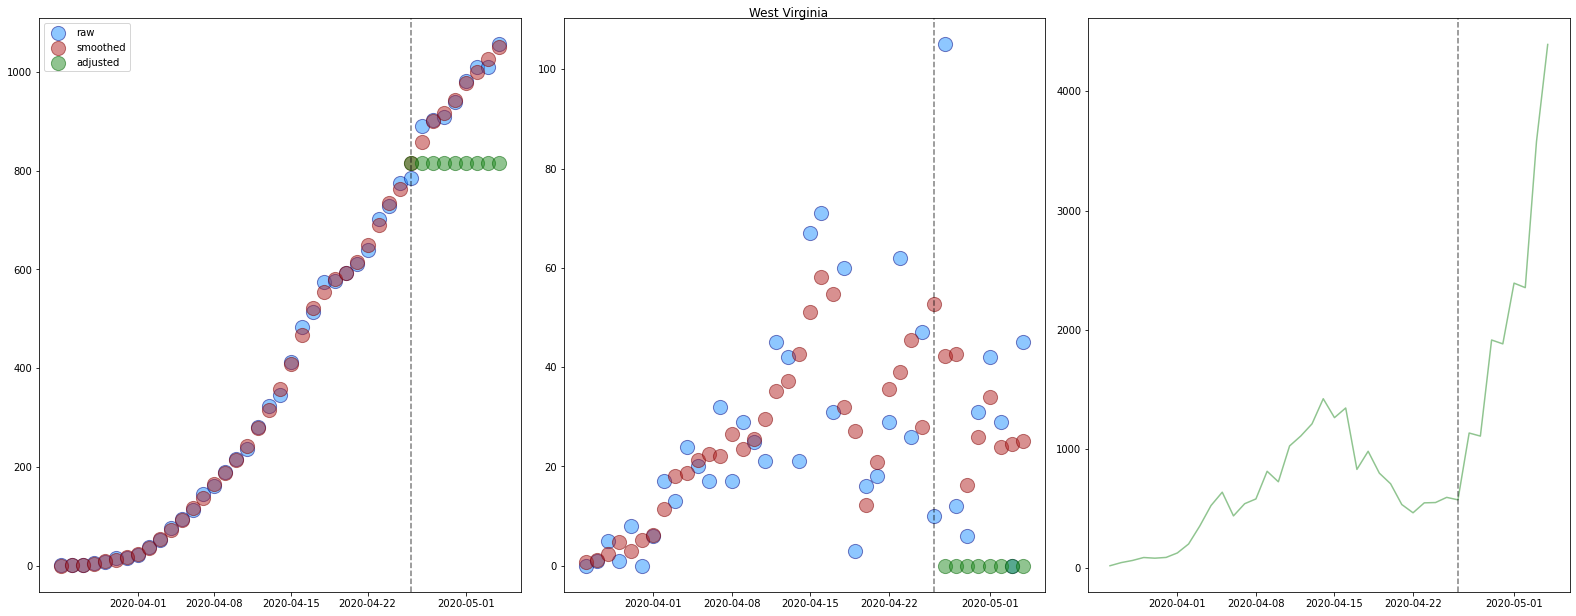

572


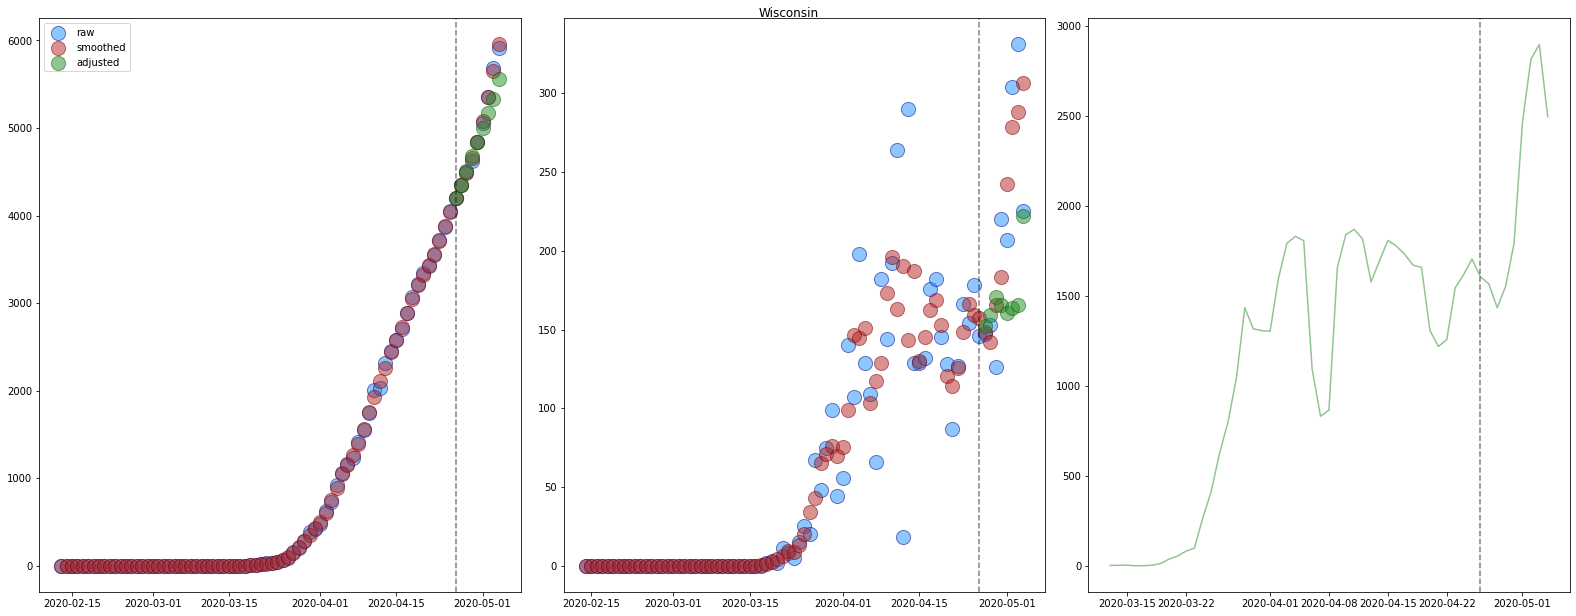

573


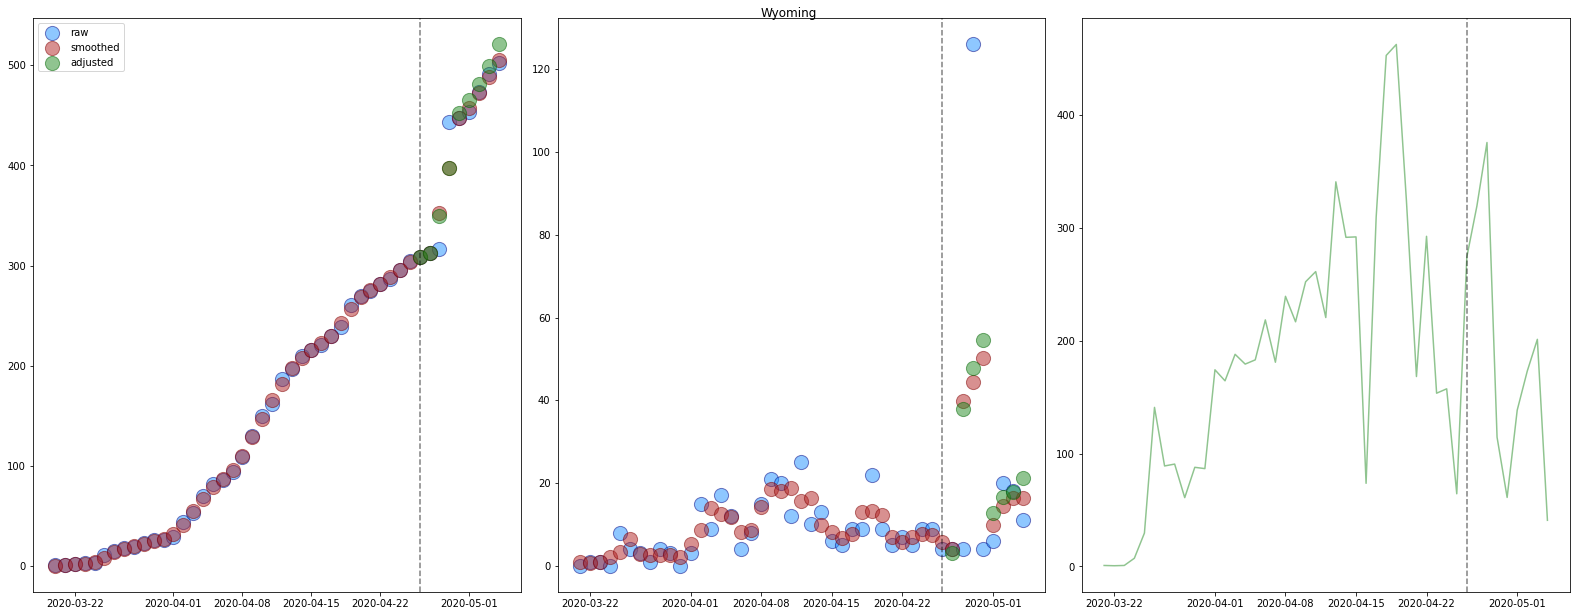

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
from db_queries import get_location_metadata

df = pd.read_csv('/ihme/homes/rmbarber/covid-19/testing_adjustment.csv')
df['Date'] = pd.to_datetime(df['Date'])
data_date = pd.to_datetime('2020-04-26')

loc_df = get_location_metadata(location_set_version_id=630, location_set_id=111)
loc_df = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['most_detailed'] == 1)]

for location_id, location_name in zip(loc_df['location_id'], loc_df['location_name']):
    print(location_id)
    plot_df = df.loc[df['location_id'] == location_id]
    if any(~plot_df['Adjusted case rate'].isnull()):
        plot_df = plot_df.sort_values('Date').reset_index(drop=True)

        fig, ax = plt.subplots(1, 3, figsize=(22, 8.5))

        ax[0].scatter(plot_df['Date'],
                      plot_df['Confirmed'],
                      c='dodgerblue', edgecolors='navy', s=200, alpha=0.5, label='raw')
        ax[0].scatter(plot_df['Date'], 
                      plot_df['Confirmed case rate'] * plot_df['population'],
                      c='firebrick', edgecolors='maroon', s=200, alpha=0.5, label='smoothed')
        ax[0].scatter(plot_df['Date'], 
                      plot_df['Adjusted case rate'] * plot_df['population'],
                      c='forestgreen', edgecolors='darkgreen', s=200, alpha=0.5, label='adjusted')
        ax[0].axvline(data_date, color='black', linestyle='--', alpha=0.5)
        ax[0].legend(loc=2)

        ax[1].scatter(plot_df['Date'][1:], plot_df['Confirmed'].values[1:] - plot_df['Confirmed'].values[:-1],
                    c='dodgerblue', edgecolors='navy', s=200, alpha=0.5)
        ax[1].scatter(plot_df['Date'][1:], 
                    (plot_df['Confirmed case rate'] * plot_df['population']).values[1:] - \
                    (plot_df['Confirmed case rate'] * plot_df['population']).values[:-1],
                    c='firebrick', edgecolors='maroon', s=200, alpha=0.5)
        ax[1].scatter(plot_df['Date'][1:], 
                    (plot_df['Adjusted case rate'] * plot_df['population']).values[1:] - \
                    (plot_df['Adjusted case rate'] * plot_df['population']).values[:-1],
                    c='forestgreen', edgecolors='darkgreen', s=200, alpha=0.5)
        ax[1].axvline(data_date, color='black', linestyle='--', alpha=0.5)

        ax[2].plot(plot_df['Date'][1:], 
                   (plot_df['Testing rate'] * plot_df['population']).values[1:] - \
                   (plot_df['Testing rate'] * plot_df['population']).values[:-1],
                   color='forestgreen', alpha=0.5)
        ax[2].axvline(data_date, color='black', linestyle='--', alpha=0.5)

        plt.suptitle(location_name, y=1.001)
        plt.tight_layout()
        plt.show()

